# Pre-processing & QA/QC

## Importing required packages 

In [69]:
library(dplyr)
library(Seurat)
library(patchwork)
library(stringr)
library(ggplot2)
library(hdf5r)
library(repr)
library(RColorBrewer)
library(tidyverse)
library(scDblFinder)
library(BiocParallel)

## Loading raw data

In [2]:
# WT 
Unfilt_WT_S1 <- Read10X_h5( "../raw_data/WT_S1.h5", use.names = TRUE, unique.features = TRUE)
Unfilt_WT_S2 <- Read10X_h5( "../raw_data/WT_S2.h5", use.names = TRUE, unique.features = TRUE)
Unfilt_WT_S3 <- Read10X_h5( "../raw_data/WT_S3.h5", use.names = TRUE, unique.features = TRUE)
Unfilt_WT_S4 <- Read10X_h5( "../raw_data/WT_S4.h5", use.names = TRUE, unique.features = TRUE)

# C246X
Unfilt_C246X_S1 <- Read10X_h5( "../raw_data/C246X_S1.h5", use.names = TRUE, unique.features = TRUE)
Unfilt_C246X_S2 <- Read10X_h5( "../raw_data/C246X_S2.h5", use.names = TRUE, unique.features = TRUE)
Unfilt_C246X_S3 <- Read10X_h5( "../raw_data/C246X_S3.h5", use.names = TRUE, unique.features = TRUE)

# 362DEL
Unfilt_362del_S1 <- Read10X_h5( "../raw_data/DEL362_S1.h5", use.names = TRUE, unique.features = TRUE)
Unfilt_362del_S2 <- Read10X_h5( "../raw_data/DEL362_S2.h5", use.names = TRUE, unique.features = TRUE)
Unfilt_362del_S3 <- Read10X_h5( "../raw_data/DEL362_S3.h5", use.names = TRUE, unique.features = TRUE)

## Creating Seurat objects 

In [3]:
# WT 
Unfilt_WT_S1_SRAT <- CreateSeuratObject(counts = Unfilt_WT_S1, project = "NOVO_WHOLE_SAMPLE_WT_1", min.cells = 3, min.features = 200)
Unfilt_WT_S2_SRAT <- CreateSeuratObject(counts = Unfilt_WT_S2, project = "NOVO_WHOLE_SAMPLE_WT_2", min.cells = 3, min.features = 200)
Unfilt_WT_S3_SRAT <- CreateSeuratObject(counts = Unfilt_WT_S3, project = "NOVO_WHOLE_SAMPLE_WT_3", min.cells = 3, min.features = 200)
Unfilt_WT_S4_SRAT <- CreateSeuratObject(counts = Unfilt_WT_S4, project = "NOVO_WHOLE_SAMPLE_WT_4", min.cells = 3, min.features = 200)

# C246X
Unfilt_C246X_S1_SRAT <- CreateSeuratObject(counts = Unfilt_C246X_S1, project = "NOVO_WHOLE_SAMPLE_C246X_1", min.cells = 3, min.features = 200)
Unfilt_C246X_S2_SRAT <- CreateSeuratObject(counts = Unfilt_C246X_S2, project = "NOVO_WHOLE_SAMPLE_C246X_2", min.cells = 3, min.features = 200)
Unfilt_C246X_S3_SRAT <- CreateSeuratObject(counts = Unfilt_C246X_S3, project = "NOVO_WHOLE_SAMPLE_C246X_3", min.cells = 3, min.features = 200)

# 362del
Unfilt_362del_S1_SRAT <- CreateSeuratObject(counts = Unfilt_362del_S1, project = "NOVO_WHOLE_SAMPLE_362del_1", min.cells = 3, min.features = 200)
Unfilt_362del_S2_SRAT <- CreateSeuratObject(counts = Unfilt_362del_S2, project = "NOVO_WHOLE_SAMPLE_362del_2", min.cells = 3, min.features = 200)
Unfilt_362del_S3_SRAT <- CreateSeuratObject(counts = Unfilt_362del_S3, project = "NOVO_WHOLE_SAMPLE_362del_3", min.cells = 3, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


## Merging Seurat objects + forming metadata object

In [13]:
# first merge samples for each genotype

Unfilt_WTall_SRAT <- merge(Unfilt_WT_S1_SRAT, y = c(Unfilt_WT_S2_SRAT, Unfilt_WT_S3_SRAT, Unfilt_WT_S4_SRAT), add.cell.ids = c("S1", "S2", "S3", "s4"), project = "NOVO_WHOLE_WT")
Unfilt_C246Xall_SRAT <- merge(Unfilt_C246X_S1_SRAT, y = c(Unfilt_C246X_S2_SRAT, Unfilt_C246X_S3_SRAT), add.cell.ids = c("S1", "S2", "S3"), project = "NOVO_WHOLE_C246X")
Unfilt_362all_SRAT <- merge(Unfilt_362del_S1_SRAT, y = c(Unfilt_362del_S2_SRAT, Unfilt_362del_S3_SRAT), add.cell.ids = c("S1", "S2", "S3"), project = "NOVO_WHOLE_362DEL")

# then merge genotypes to get one Seurat object
Unfilt_NOVOall_SRAT <- merge(Unfilt_WTall_SRAT, y = c(Unfilt_C246Xall_SRAT, Unfilt_362all_SRAT), add.cell.ids = c("WT", "C246X", "362del"), project = "NOVO_WHOLE_ALL")

In [21]:
#### forming metadata object from Seurat object ####

## Add mitochondrial and ribosomal genes to metadata (If many 0's check capitalisation of MT vs mt for organism)
Unfilt_NOVOall_SRAT[["percent.mt"]] <- PercentageFeatureSet(Unfilt_NOVOall_SRAT, pattern = "^mt-")
Unfilt_NOVOall_SRAT[["percent.rb"]] <- PercentageFeatureSet(Unfilt_NOVOall_SRAT, pattern = "^RP[SL]")

## Add a metadata column for viewing all samples at the same time
Unfilt_NOVOall_SRAT[["ALL"]] <- "view_all"

## Add number of genes per UMI for each cell and mitochondrial ratio to metadata

# UMI
Unfilt_NOVOall_SRAT$log10GenesPerUMI <- log10(Unfilt_NOVOall_SRAT$nFeature_RNA) / log10(Unfilt_NOVOall_SRAT$nCount_RNA)

# Compute percent mito ratio
Unfilt_NOVOall_SRAT$mitoRatio <- PercentageFeatureSet(object = Unfilt_NOVOall_SRAT, pattern = "^mt-")
Unfilt_NOVOall_SRAT$mitoRatio <- Unfilt_NOVOall_SRAT@meta.data$mitoRatio / 100

## New metadata frame for deeper QC
Unfilt_NOVOall_SRAT_metadata <- Unfilt_NOVOall_SRAT@meta.data

# Make a column with cell ID's
Unfilt_NOVOall_SRAT_metadata$cells <- rownames(Unfilt_NOVOall_SRAT_metadata)

# Create a new column with genotype 
Unfilt_NOVOall_SRAT_metadata = Unfilt_NOVOall_SRAT_metadata %>%
                                mutate(genotype = case_when(
                                                    str_detect(cells, "WT") ~ "WT",
                                                    str_detect(cells, "C246X") ~ "C246X",
                                                    str_detect(cells, "362") ~ "362del"))

# Add the metadata from dataframe into the seurat object
Unfilt_NOVOall_SRAT@meta.data <- Unfilt_NOVOall_SRAT_metadata

In [29]:
# add a sample column to have each sample as a different colour, add cell count col to count cells by sample and genotype
Unfilt_NOVOall_SRAT_metadata_final = Unfilt_NOVOall_SRAT_metadata %>% 
    mutate(sample = case_when(
                        str_detect(orig.ident, "_1") ~ "1",
                        str_detect(orig.ident, "_2") ~ "2",
                        str_detect(orig.ident, "_3") ~ "3",
                        str_detect(orig.ident, "_4") ~ "4")) %>%
    group_by(orig.ident) %>%  
    mutate(cell_count = n()) %>% # not using the count function bc all the other cols will disappear
    ungroup()


Save the files to rds objects to load later

In [31]:
# save unfiltered Seurat object to load later 
user_file_directory_unfiltsrat = readline(prompt = "Please enter file directory to save Unfilt_NOVOall_SRAT: ") # remember to add .rds extension after file name 
saveRDS(Unfilt_NOVOall_SRAT, file = user_file_directory_unfiltsrat) 

Please enter file directory to save Unfilt_NOVOall_SRAT:  ../data_files/Unfilt_NOVOall_SRAT.rds


In [32]:
# save unfiltered metadata to load later
user_file_directory_unfiltmeta = readline(prompt = "Please enter file directory to save Unfilt_NOVOall_SRAT_metadata_final: ") # remember to add .rds extension after file name
saveRDS(Unfilt_NOVOall_SRAT_metadata_final, file = user_file_directory_unfiltmeta) 

Please enter file directory to save Unfilt_NOVOall_SRAT_metadata_final:  ../data_files/Unfilt_NOVOall_SRAT_metadata_final.rds


In [33]:
# load both the files
Unfilt_NOVOall_SRAT = readRDS(user_file_directory_unfiltsrat)
Unfilt_NOVOall_SRAT_metadata_final = readRDS(user_file_directory_unfiltmeta)

## ***Unfiltered data visualisation***

## Looking at number of cells per sample and genotype

### Per sample

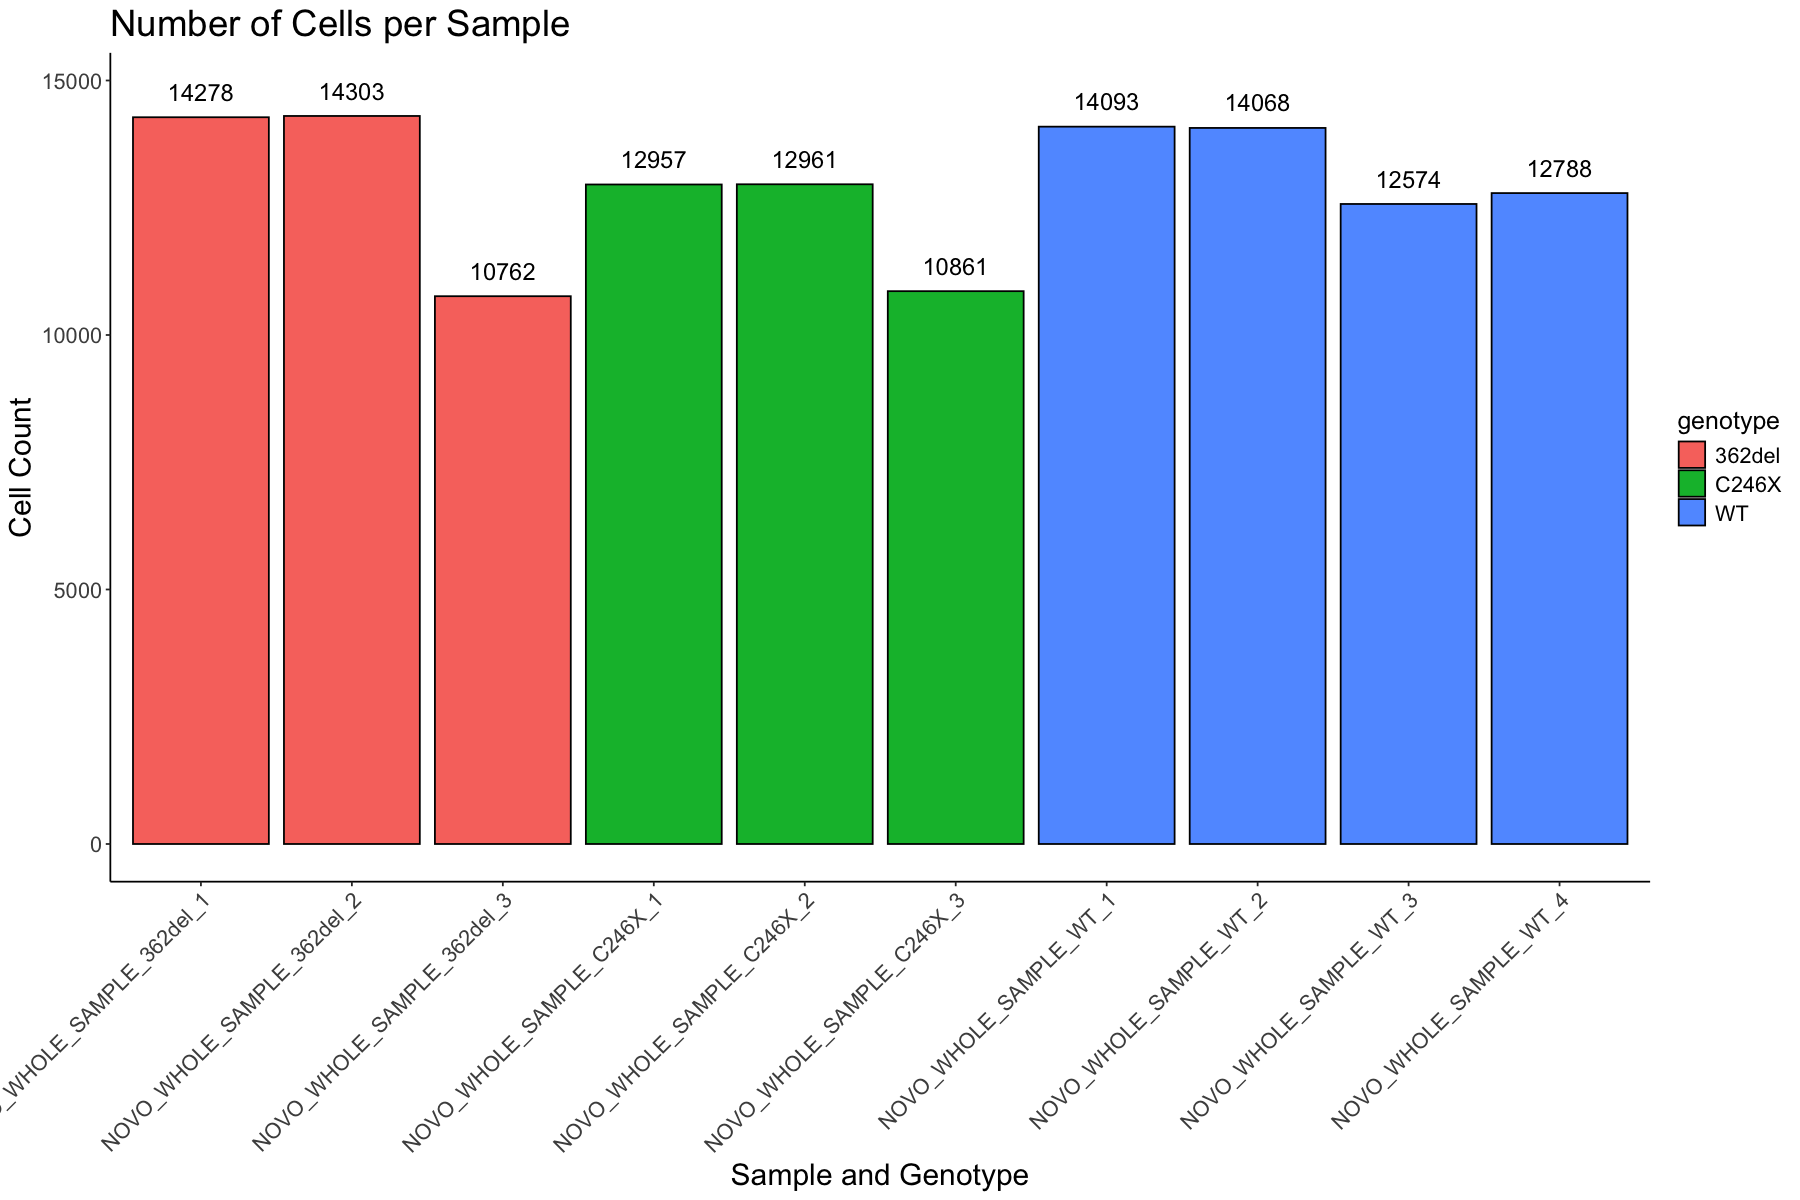

In [34]:
options(repr.plot.width=15, repr.plot.height=10)

Unfilt_NOVOall_SRAT_metadata_final %>%
  distinct(orig.ident, .keep_all = TRUE) %>% # remove the duplicate values so we can have one value per row, keep all cols
  ggplot(aes(x = orig.ident, y = cell_count)) + 
  	geom_col(aes(fill = genotype), color = "black") + 
    geom_text(aes(label = cell_count), nudge_y = 500, size = 5) +
    theme_classic() + 
    labs(x = "Sample and Genotype", y = "Cell Count") + 
    ggtitle("Number of Cells per Sample") + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 22))
    

### Per genotype

[1] 129645


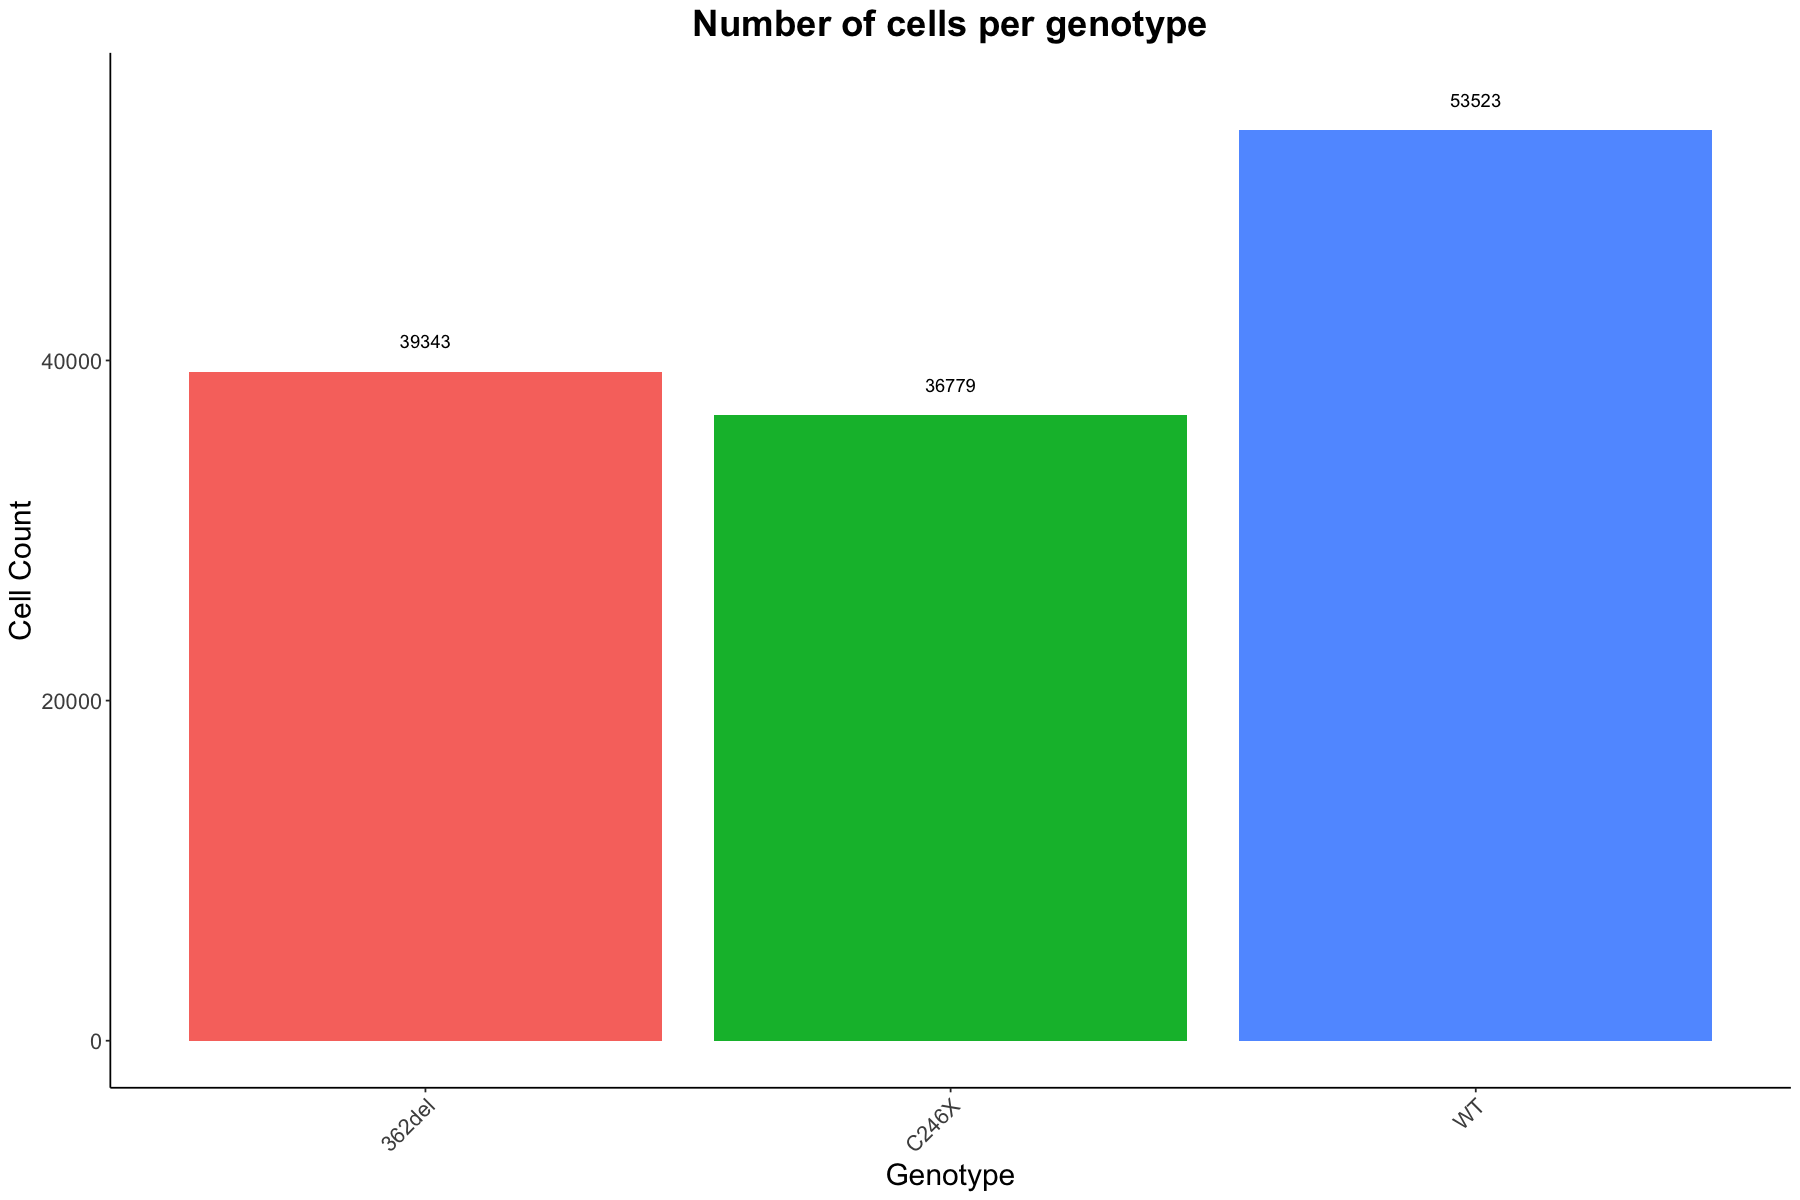

In [37]:
Unfilt_NOVOall_SRAT_metadata_final %>% 
  	ggplot(aes(x=genotype, fill=genotype)) + 
  	geom_bar() +
    geom_text(aes(label = after_stat(count)), stat = "count", nudge_y = 1800) +
  	theme_classic() +
  	theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  	theme(plot.title = element_text(hjust=0.5, face="bold"), 
  	      legend.position = "none") +
    labs(x = "Genotype", y = "Cell Count") + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 22)) + 
  	ggtitle("Number of cells per genotype") 

# print total cell count 
print(dim(Unfilt_NOVOall_SRAT_metadata)[1])

## Visualize the number UMIs/transcript counts per cell

In [38]:
x_intercept1 = as.numeric(readline(prompt = "Please enter a base UMI count: "))

Please enter a base UMI count:  500


### Per genotype

In [42]:
Unfilt_NOVOall_SRAT_metadata_final %>% 
  ggplot(aes(color = genotype, x = nCount_RNA, fill = genotype)) + 
  geom_density(alpha = 0.2) + 
  scale_x_log10() + 
  theme_classic() +
  ylab("Cell density") +
  geom_vline(xintercept = x_intercept1) + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15))

### Per sample

In [45]:
options(repr.plot.width=20, repr.plot.height=10)

Unfilt_NOVOall_SRAT_metadata_final %>% 
  ggplot(aes(color = sample, x = nCount_RNA, fill = sample)) + 
  geom_density(alpha = 0.2) +
  theme_classic() +
  scale_x_log10() + 
  ylab("Cell density") +
  geom_vline(xintercept = x_intercept1) + 
  labs(x = "Log RNA Count") + 
  ggtitle("RNA Count per cell per sample") + 
  facet_wrap(~genotype) + 
  theme(axis.text.x = element_text(size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 20),
          strip.text = element_text(size = 17)) # size of title for each facet

## Visualize the distribution of genes (features) detected per cell

"For high quality data, the proportional histogram should contain a single large peak that represents cells that were encapsulated. If we see a small shoulder to the right of the major peak (not present in our data), or a bimodal distribution of the cells, that can indicate a couple of things. It might be that there are a set of cells that failed for some reason. It could also be that there are biologically different types of cells (i.e. quiescent cell populations, less complex cells of interest), and/or one type is much smaller than the other (i.e. cells with high counts may be cells that are larger in size)."

In [46]:
x_intercept3 = as.numeric(readline(prompt = "Please enter a base featureRNA count: "))

Please enter a base featureRNA count:  300


### Per genotype

In [47]:
Unfilt_NOVOall_SRAT_metadata_final %>% 
  	ggplot(aes(color=genotype, x=nFeature_RNA, fill= genotype)) + 
  	geom_density(alpha = 0.2) + 
  	theme_classic() +
  	scale_x_log10() + 
    labs(x = "Number of feature RNA", y = "Density") + 
  	geom_vline(xintercept = x_intercept3) + 
    theme(axis.text.x = element_text(size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 20),
          strip.text = element_text(size = 17))

### Per sample

In [48]:
Unfilt_NOVOall_SRAT_metadata_final %>% 
  	ggplot(aes(color=sample, x=nFeature_RNA, fill= sample)) + 
  	geom_density(alpha = 0.2) + 
  	theme_classic() +
  	scale_x_log10() + 
    labs(x = "Number of FeatureRNA", y = "Density") + 
  	geom_vline(xintercept = x_intercept3) + 
    theme(axis.text.x = element_text(size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 20),
          strip.text = element_text(size = 17)) + 
    facet_wrap(~genotype)

## Visualize the correlation between genes detected and number of UMIs

Determine whether strong presence of cells with low numbers of genes/UMIs

"Cells that are poor quality are likely to have low genes and UMIs per cell, and correspond to the data points in the bottom left quadrant of the plot. Good cells will generally exhibit both higher number of genes per cell and higher numbers of UMIs

With this plot we also evaluate the slope of the line, and any scatter of data points in the bottom right hand quadrant of the plot. These cells have a high number of UMIs but only a few number of genes. These could be dying cells, but also could represent a population of a low complexity celltype (i.e red blood cells)."

In [49]:
x_int4 = as.numeric(readline(prompt = "Please enter RNA Count: ")) # 500 
y_int1 = as.numeric(readline(prompt = "Please enter Feature RNA: ")) # 300

Please enter RNA Count:  500
Please enter Feature RNA:  300


In [50]:
Unfilt_NOVOall_SRAT_metadata_final %>% 
  	ggplot(aes(x=nCount_RNA, y=nFeature_RNA)) + 
  	geom_point(aes(color=mitoRatio)) + 
	scale_colour_gradient(low = "lightpink", high = "violetred4") +
  	stat_smooth(method=lm) +
  	scale_x_log10() + 
  	scale_y_log10() + 
  	theme_classic() +
  	geom_vline(xintercept = x_int4) +
  	geom_hline(yintercept = y_int1) +
  	facet_wrap(~genotype) + 
    theme(axis.text.x = element_text(size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 20),
          strip.text = element_text(size = 17))


`geom_smooth()` using formula = 'y ~ x'


The following plot is similar to the line plot above. We visualize the complexity of the gene expression by visualizing the genes detected per UMI

"We can see the samples where we sequenced each cell less have a higher overall complexity, that is because we have not started saturating the sequencing for any given gene for these samples. Outlier cells in these samples might be cells that have a less complex RNA species than other cells. Sometimes we can detect contamination with low complexity cell types like red blood cells via this metric. Generally, we expect the novelty score to be above 0.80."

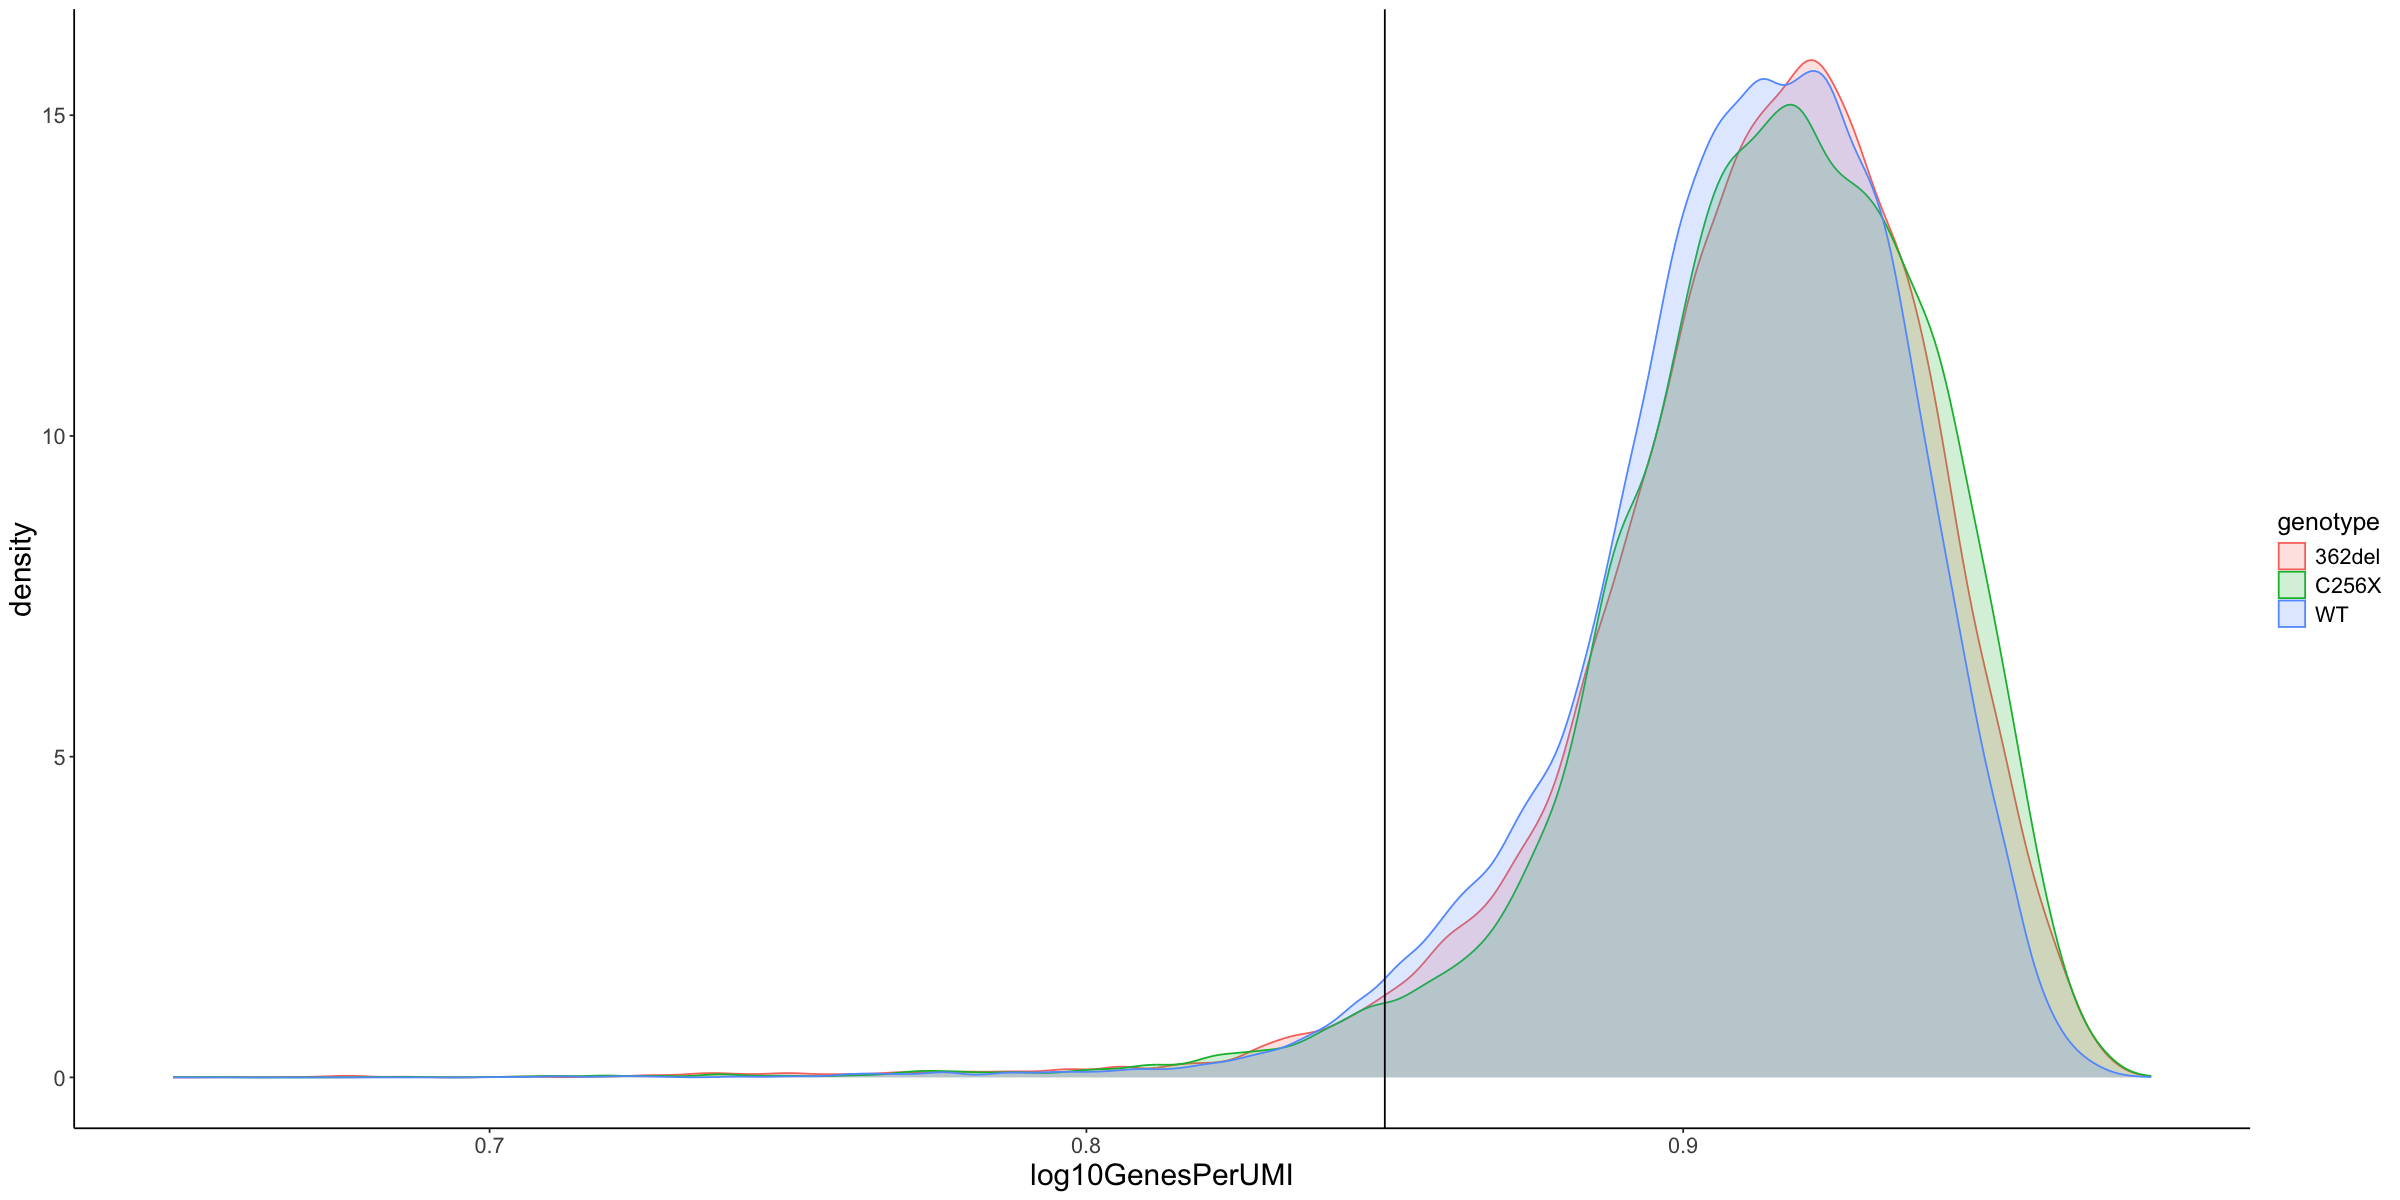

In [95]:
Unfilt_NOVOall_SRAT_metadata_final %>%
  	ggplot(aes(x=log10GenesPerUMI, color = genotype, fill=genotype)) +
  	geom_density(alpha = 0.2) +
  	theme_classic() +
  	geom_vline(xintercept = 0.85) + 
    theme(axis.text.x = element_text(size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 20),
          strip.text = element_text(size = 17))

## Visualize the distribution of mitochondrial gene expression detected per cell

"This metric can identify whether there is a large amount of mitochondrial contamination from dead or dying cells. We define poor quality samples for mitochondrial counts as cells which surpass the 0.2 mitochondrial ratio mark, unless of course you are expecting this in your sample."

In [51]:
x_int5 = as.numeric(readline(prompt = "Please enter a cut-off value for mito ratio: "))

Please enter a cut-off value for mito ratio:  0.1


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 52 rows containing non-finite outside the scale range
(`stat_density()`).”


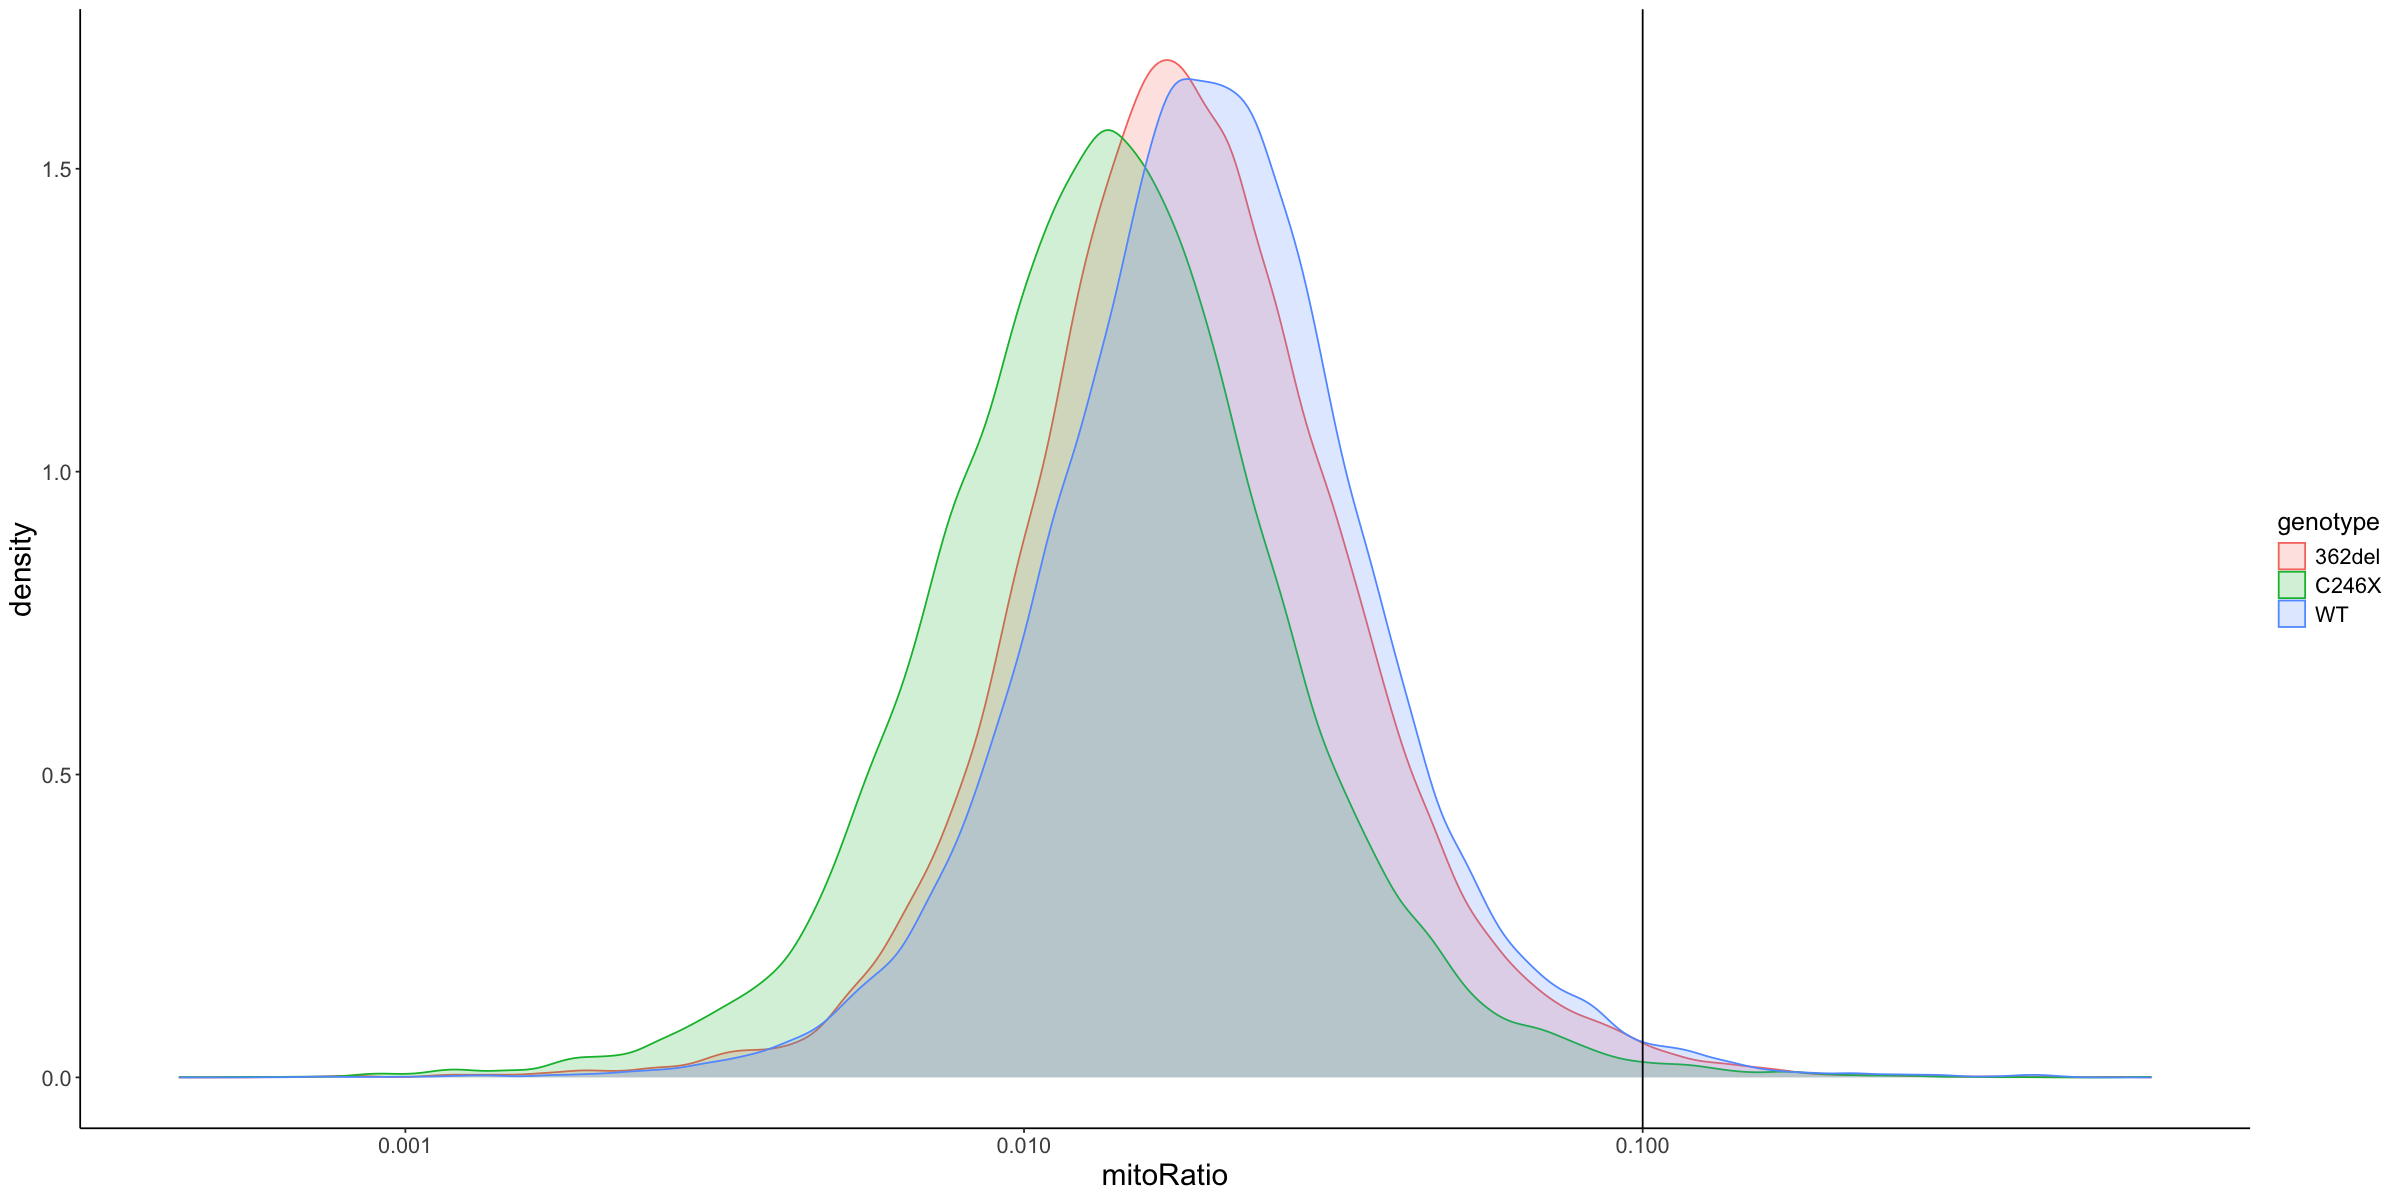

In [52]:
Unfilt_NOVOall_SRAT_metadata_final %>% 
  	ggplot(aes(color=genotype, x=mitoRatio, fill=genotype)) + 
  	geom_density(alpha = 0.2) + 
  	scale_x_log10() + 
  	theme_classic() +
  	geom_vline(xintercept = x_int5) + 
    theme(axis.text.x = element_text(size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 20),
          strip.text = element_text(size = 17))

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 52 rows containing non-finite outside the scale range
(`stat_density()`).”


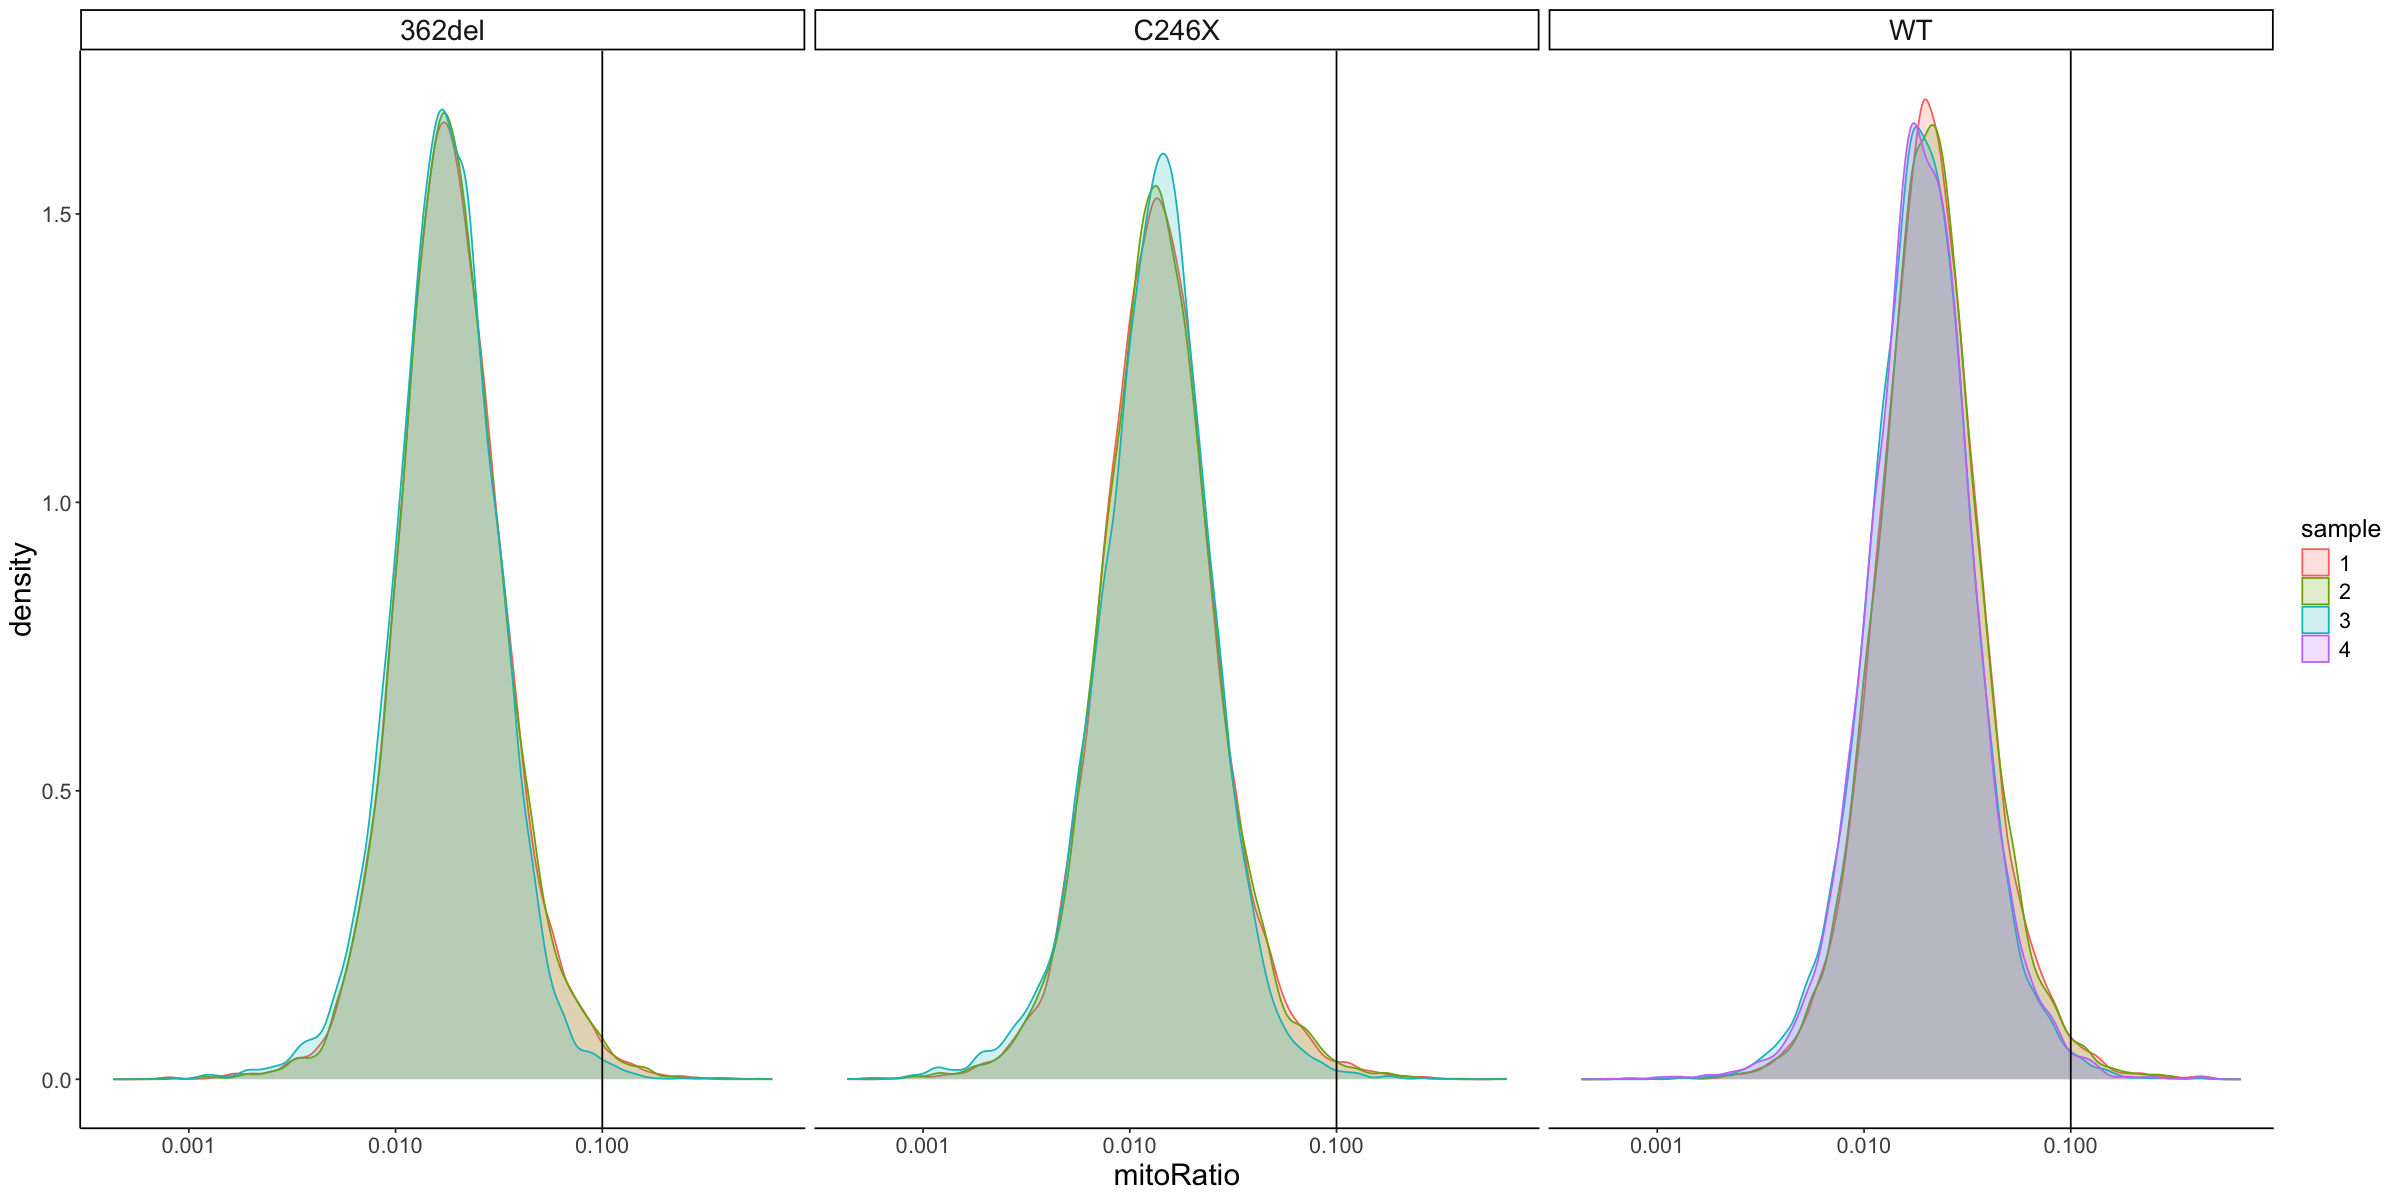

In [53]:
Unfilt_NOVOall_SRAT_metadata_final %>% 
  	ggplot(aes(color=sample, x=mitoRatio, fill=sample)) + 
  	geom_density(alpha = 0.2) + 
  	scale_x_log10() + 
  	theme_classic() +
  	geom_vline(xintercept = x_int5) + 
    theme(axis.text.x = element_text(size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 20),
          strip.text = element_text(size = 17)) + 
    facet_wrap(~genotype)

## QC step visualisation

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


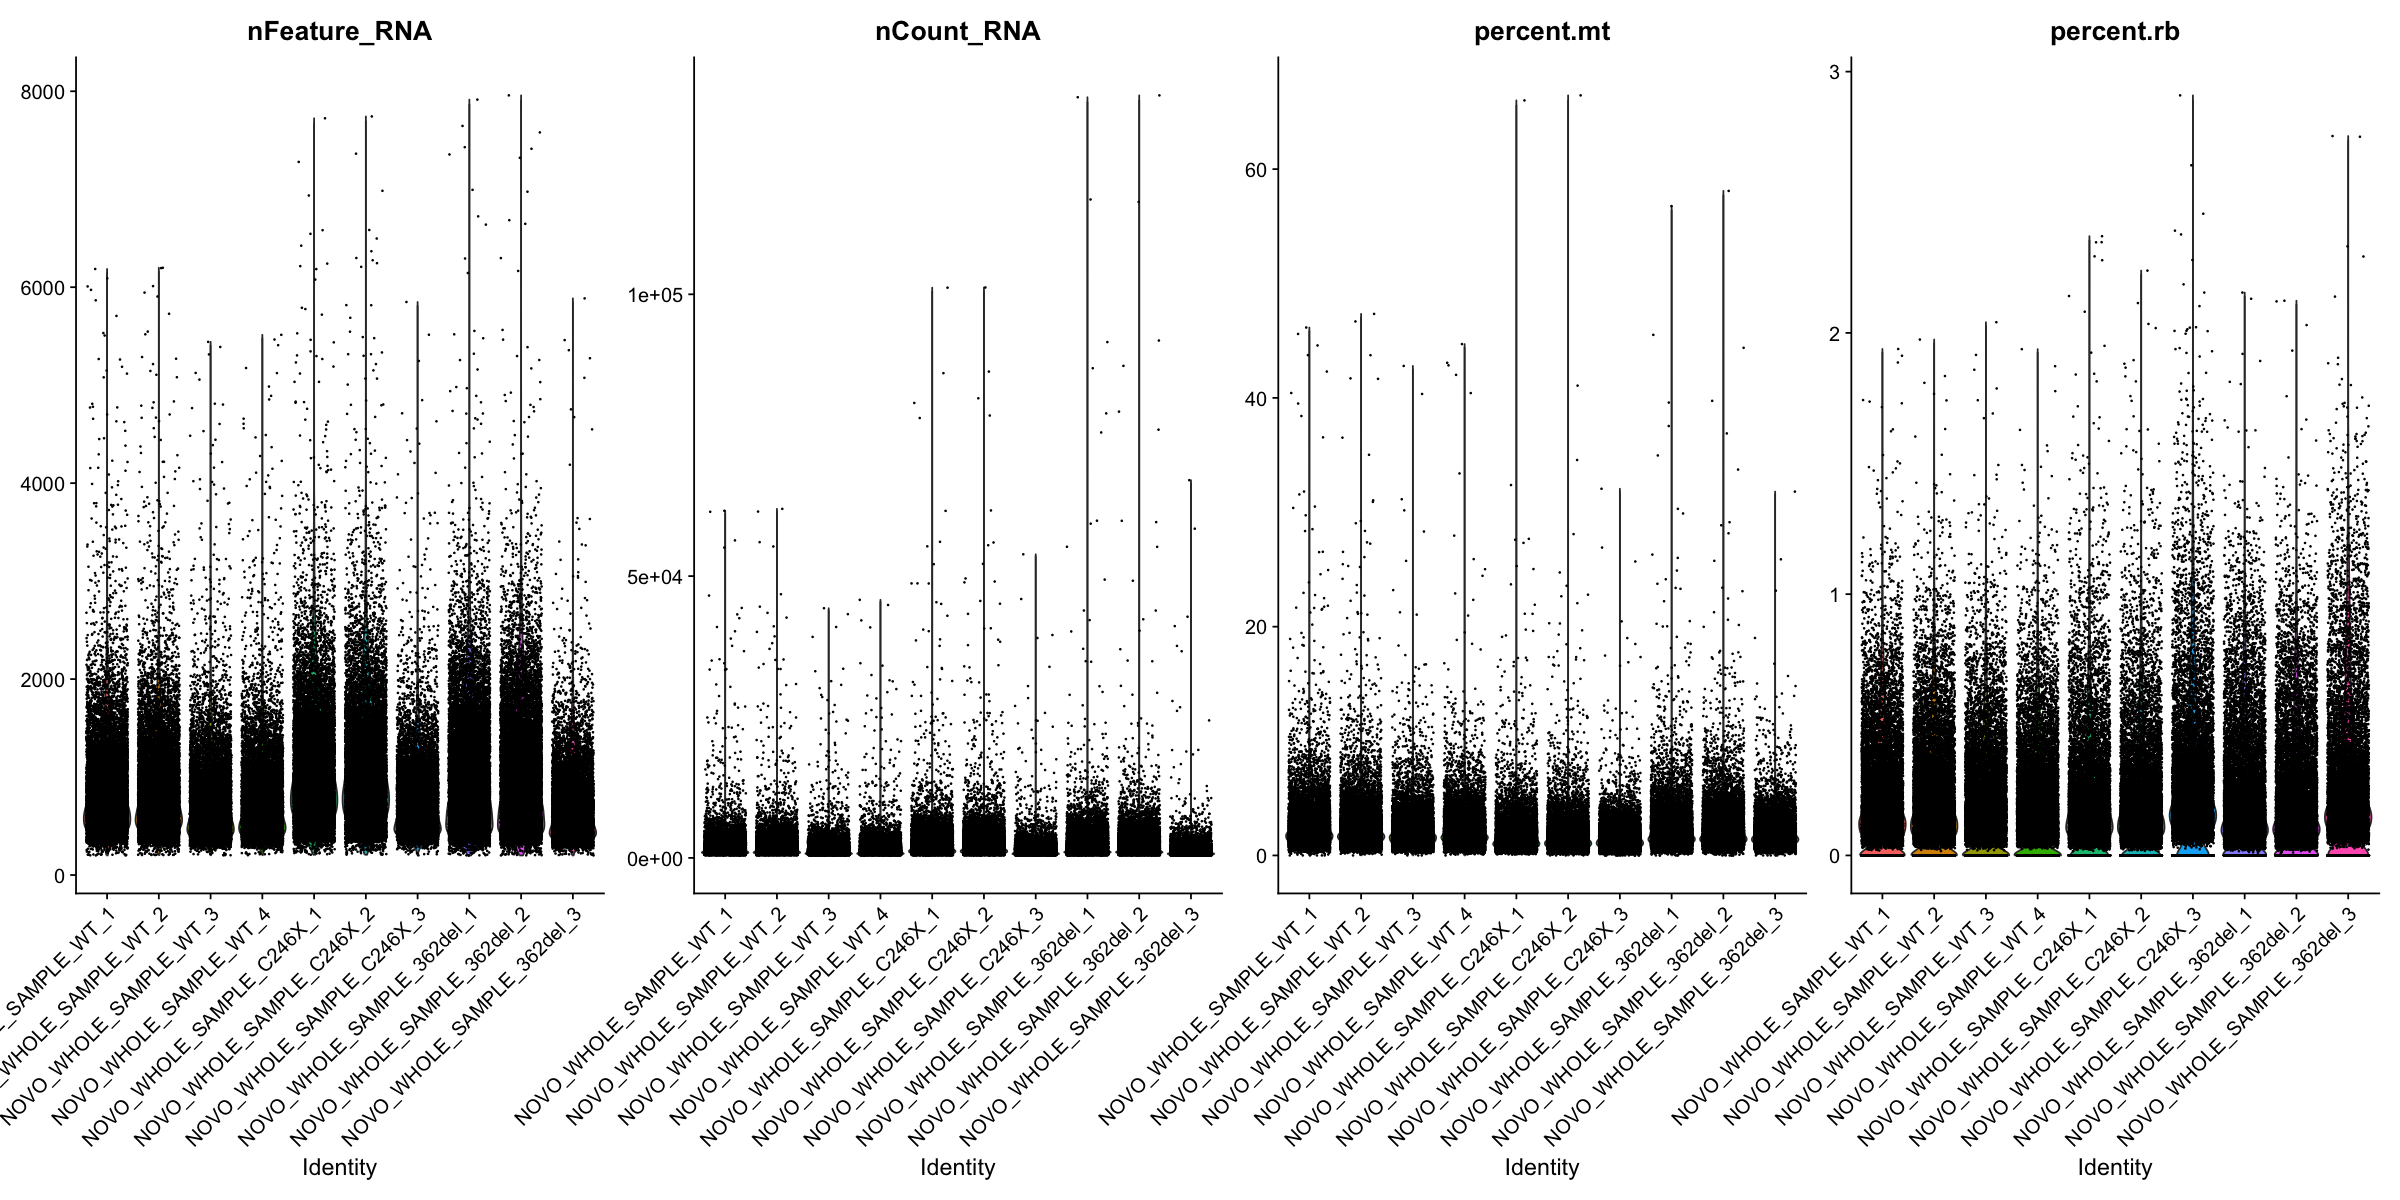

In [99]:
# Visualize QC metrics as a violin plot
VlnPlot(Unfilt_NOVOall_SRAT, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, raster=FALSE)

## Plot counts vs mitochondrial counts and counts vs features

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



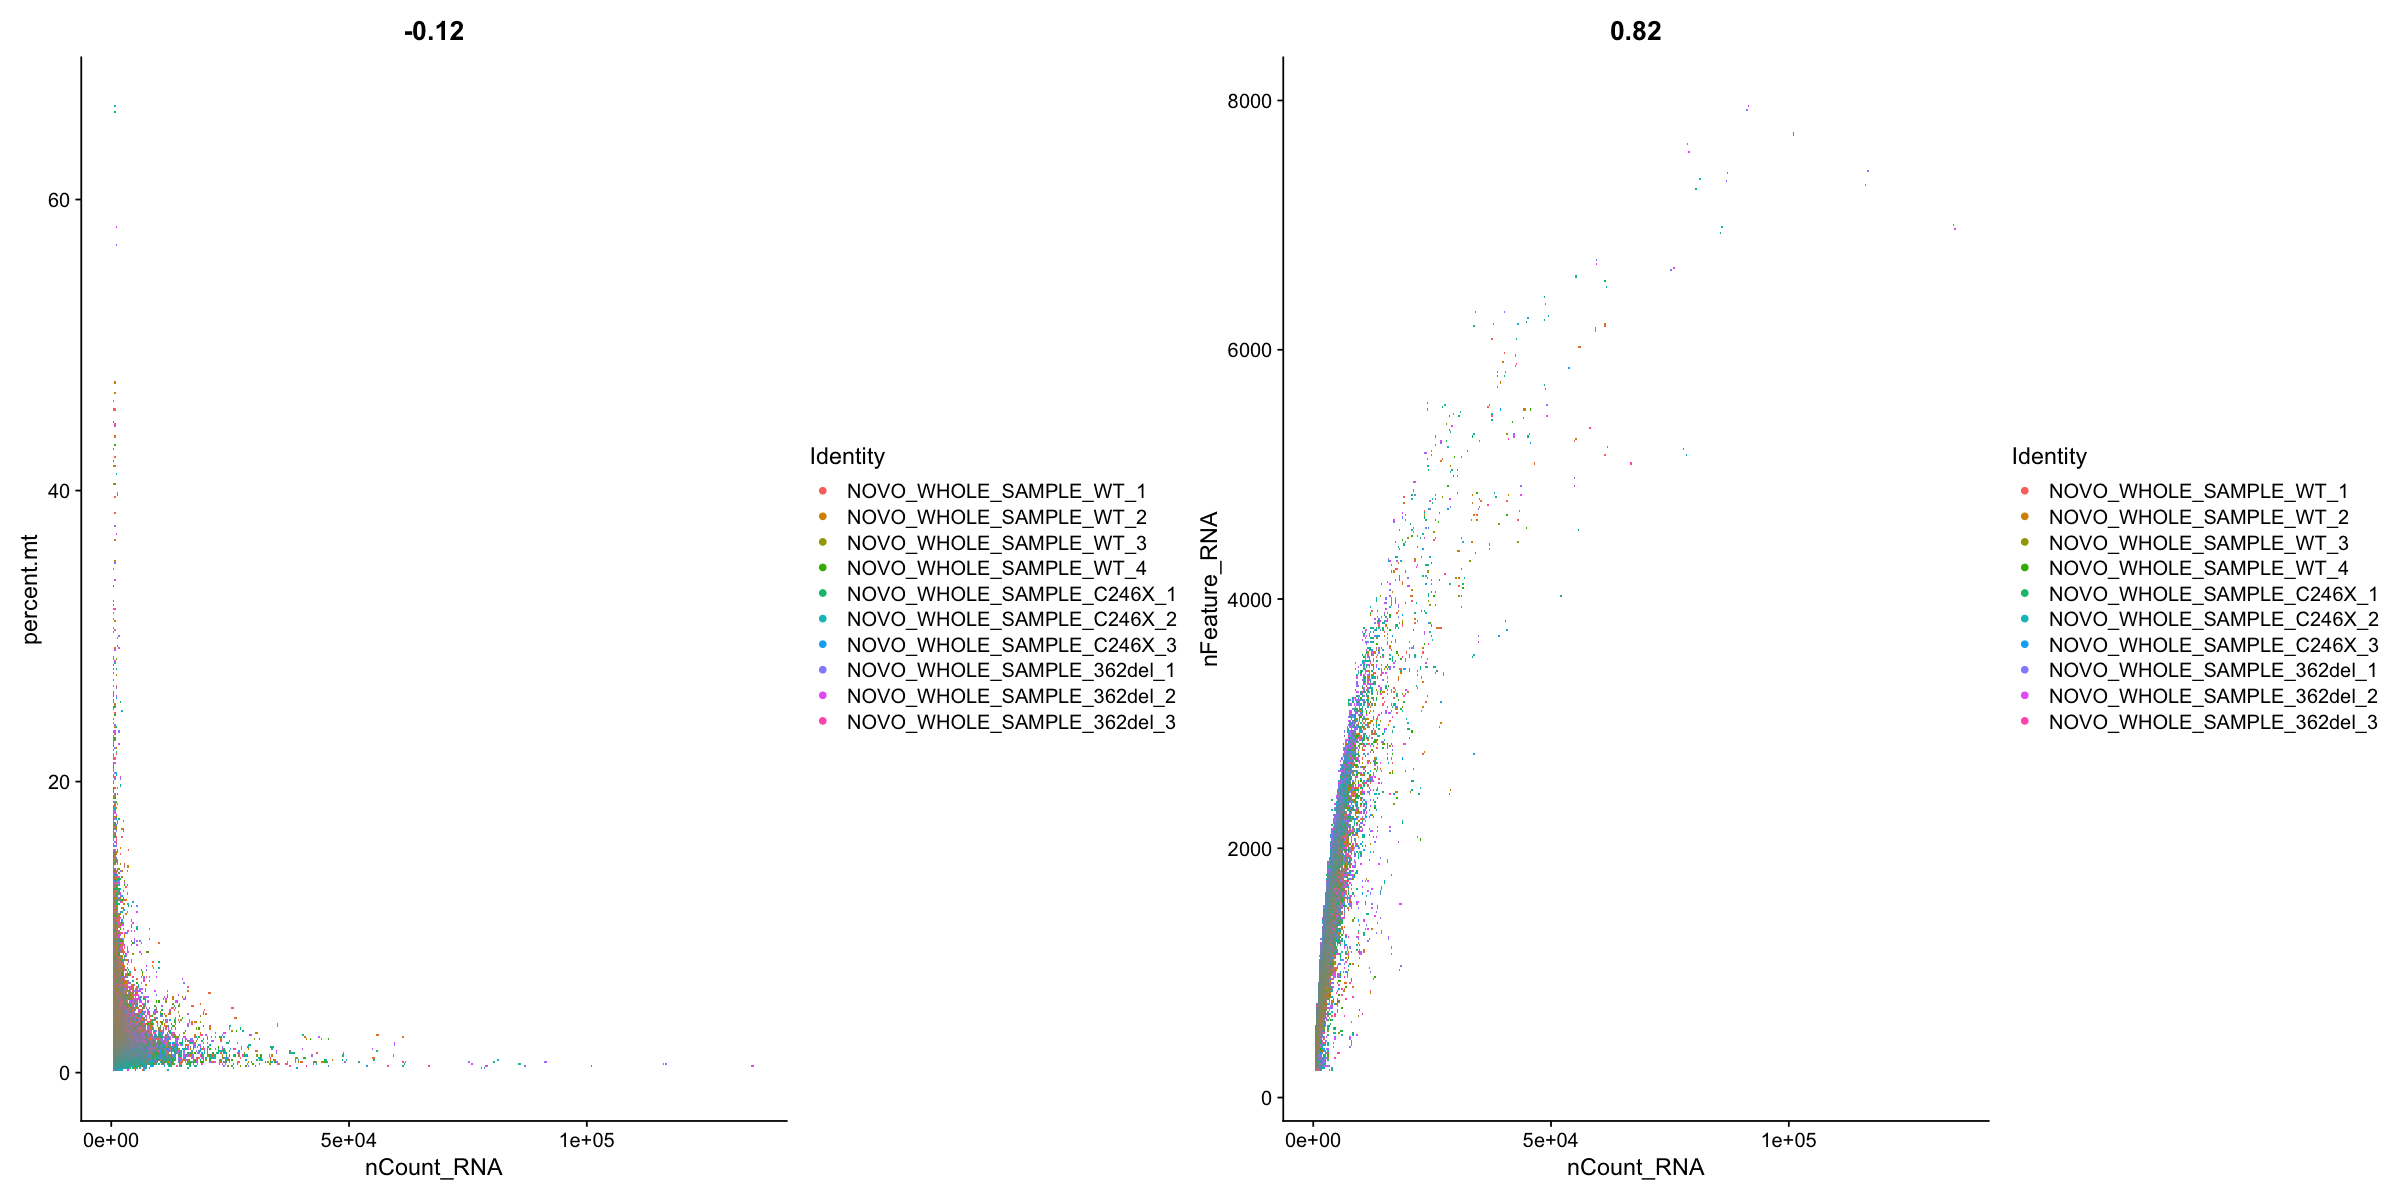

In [100]:
plot1 <- FeatureScatter(Unfilt_NOVOall_SRAT, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(Unfilt_NOVOall_SRAT, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

## ***Filter the data*** 

## Filter out low quality using selected thresholds

In [54]:
RNA_count_LB = as.numeric(readline(prompt = "Please enter a lower bound for RNA count: ")) # lower bound for RNA count (500)
RNA_count_UP = as.numeric(readline(prompt = "Please enter an upper bound for RNA count: ")) # 10000
feature_RNA = as.numeric(readline(prompt = "Please enter a feature RNA cutoff value: ")) # 300
log10genesPerUMI = as.numeric(readline(prompt = "Please enter a feature RNA cutoff value: ")) # 0.85
percent_mt = as.numeric(readline(prompt = "Please enter a mito percent cutoff value: ")) # 7.5
mitoratio = as.numeric(readline(prompt = "Please enter a mitoratio cutoff value: ")) # 0.1

Please enter a lower bound for RNA count:  500
Please enter an upper bound for RNA count:  10000
Please enter a feature RNA cutoff value:  300
Please enter a feature RNA cutoff value:  0.85
Please enter a mito percent cutoff value:  7.5
Please enter a mitoratio cutoff value:  0.1


In [55]:
Filt_1_NOVOall_SRAT <- subset(x = Unfilt_NOVOall_SRAT, 
                         subset= ( Unfilt_NOVOall_SRAT$nCount_RNA>= RNA_count_LB) &
                           (Unfilt_NOVOall_SRAT$nCount_RNA<= RNA_count_UP) &
                           (Unfilt_NOVOall_SRAT$nFeature_RNA >= feature_RNA) & 
                           (log10GenesPerUMI > log10genesPerUMI) & 
                           (Unfilt_NOVOall_SRAT$percent.mt < percent_mt) &
                           (mitoRatio < mitoratio))

In [56]:
# save filtered seurat object
dir_filtsrat = readline(prompt = "Please enter file directory to save Filt_1_NOVOall_SRAT: ")
saveRDS(Filt_1_NOVOall_SRAT, dir_filtsrat)

Please enter file directory to save Filt_1_NOVOall_SRAT:  ../data_files/Filt_1_NOVOall_SRAT.rds


In [57]:
# load the file 
Filt_1_NOVOall_SRAT = readRDS(dir_filtsrat)

## Revisualise and recount sample cells

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


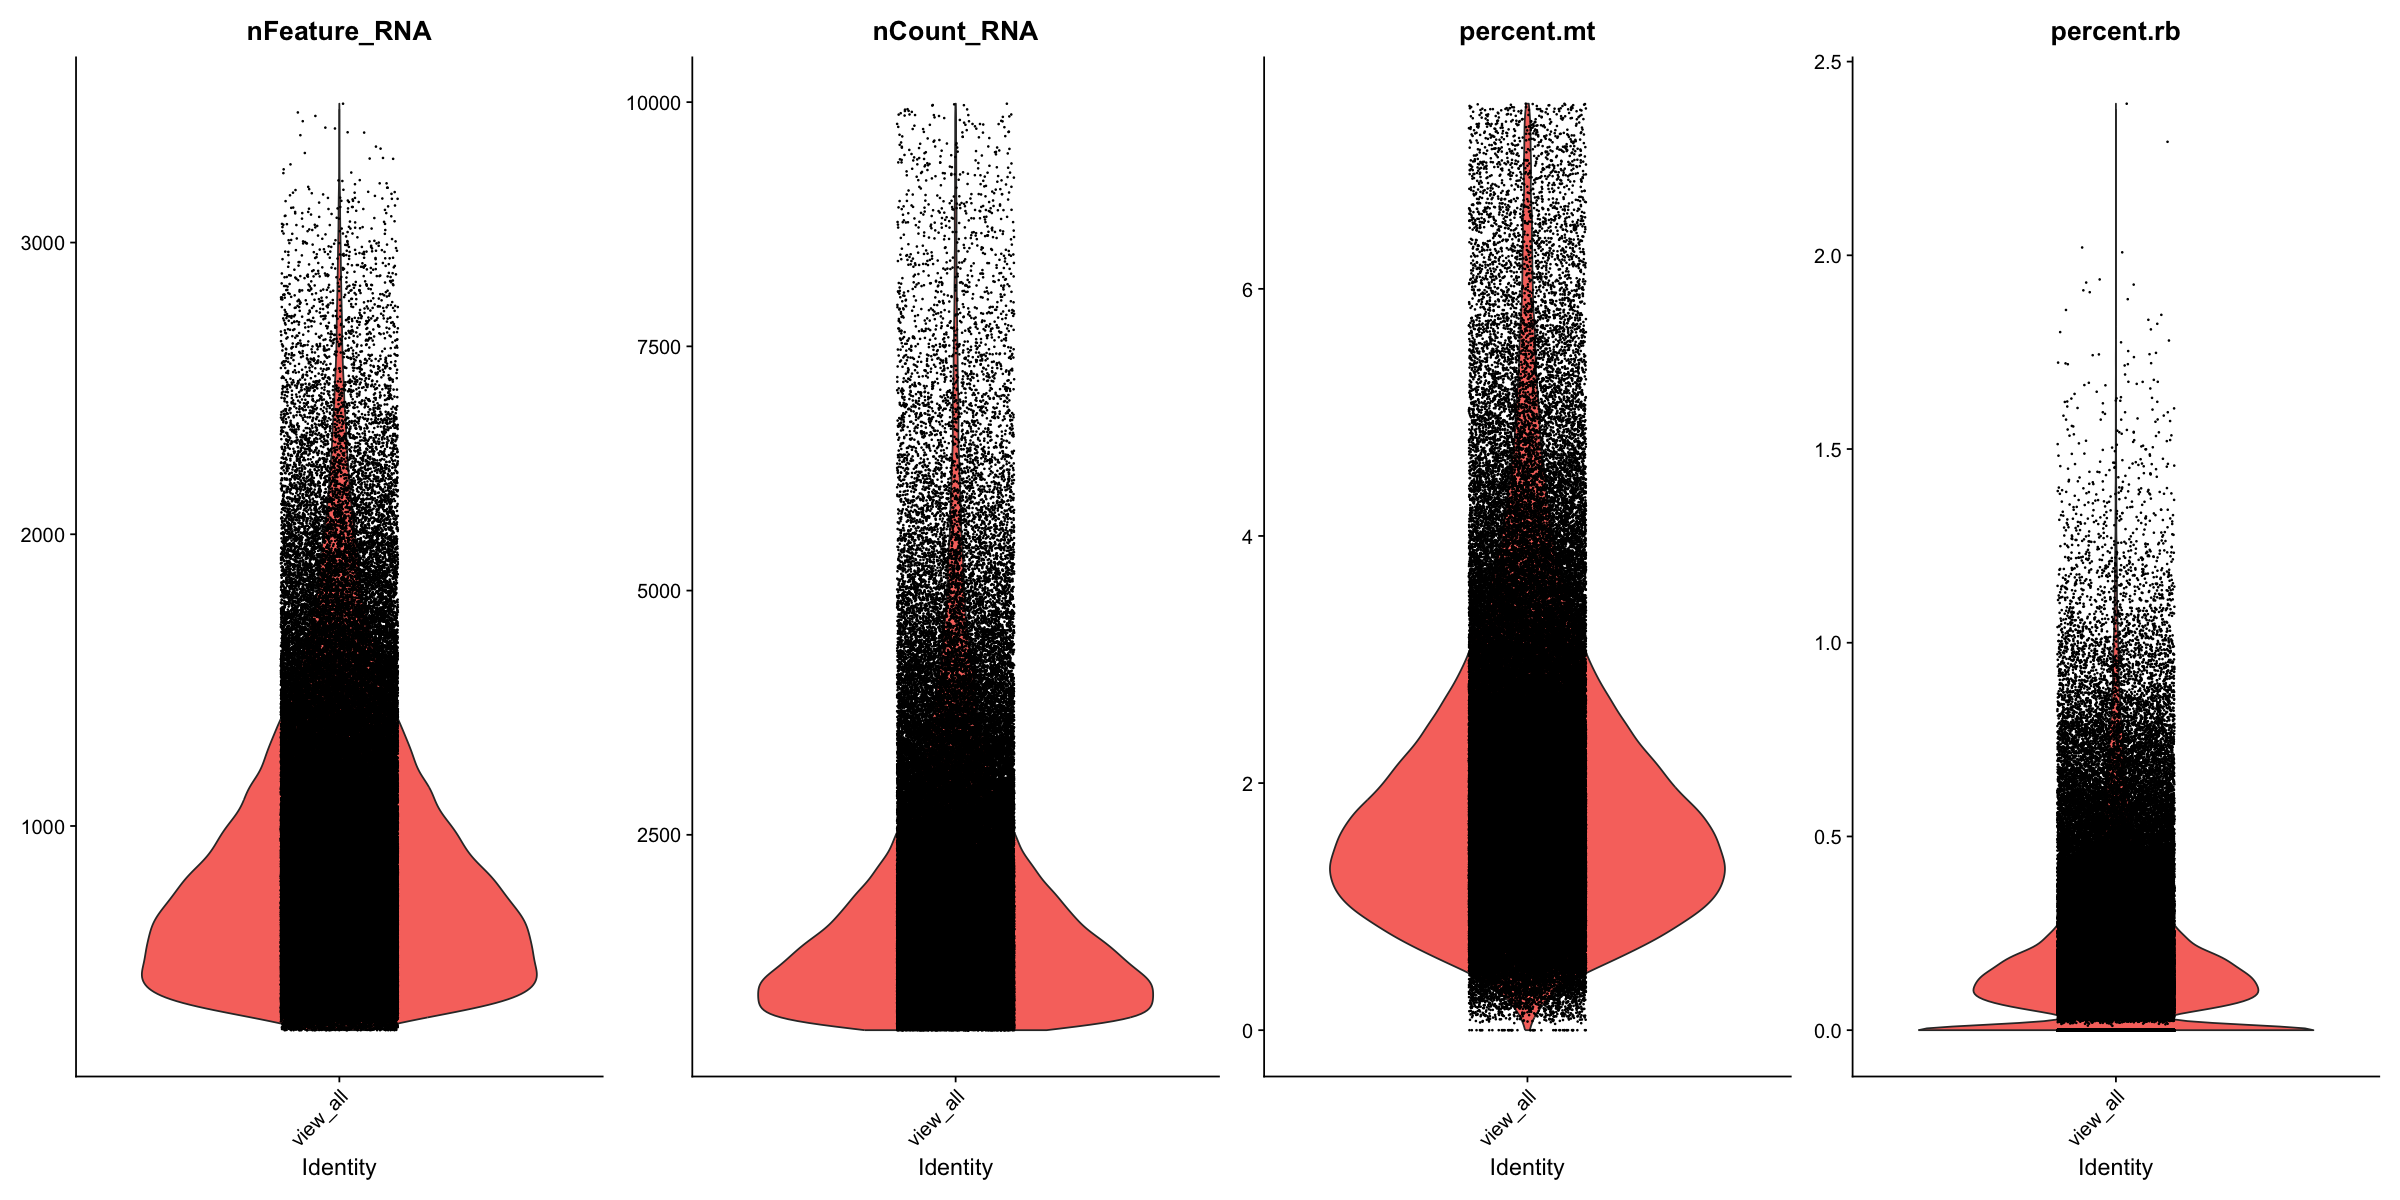

In [103]:
# Visualize QC metrics as a violin plot
VlnPlot(Filt_1_NOVOall_SRAT, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), ncol = 4, split.by = "ALL", group.by = "ALL", raster=FALSE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



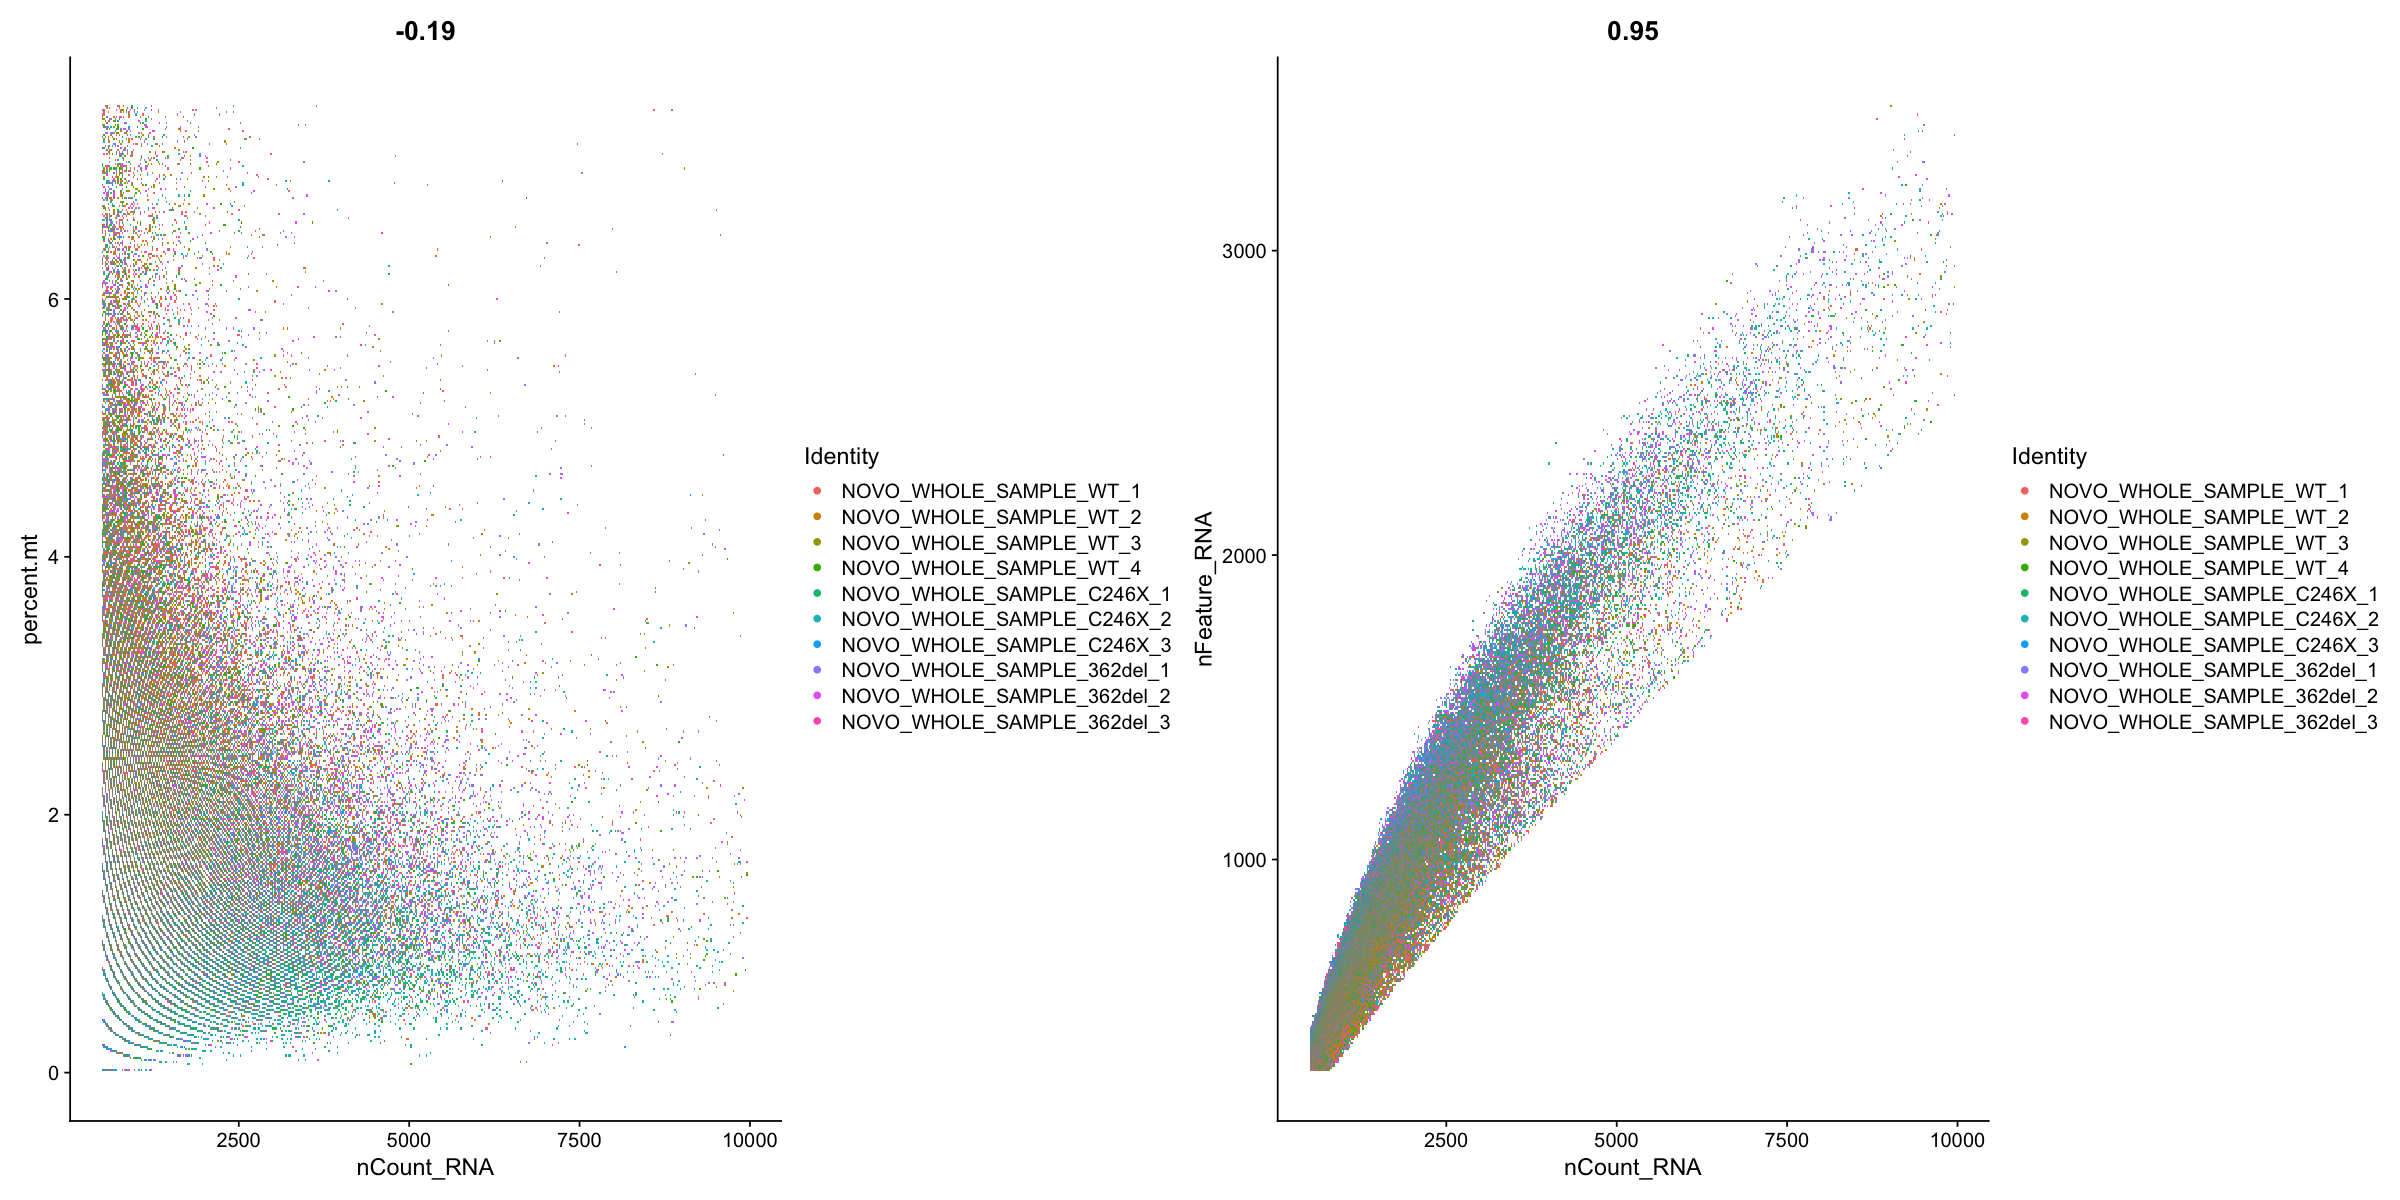

In [104]:
plot1_post <- FeatureScatter(Filt_1_NOVOall_SRAT, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2_post <- FeatureScatter(Filt_1_NOVOall_SRAT, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1_post + plot2_post

## Number of cells post filtering 

In [58]:
Filt_1_NOVOall_SRAT_metadata = Filt_1_NOVOall_SRAT@meta.data

In [60]:
# add a sample column to have each sample as a different colour, add cell count col to count cells by sample and genotype
Filt_1_NOVOall_SRAT_metadata_final = Filt_1_NOVOall_SRAT_metadata %>% 
    mutate(sample = case_when(
                        str_detect(orig.ident, "_1") ~ "1",
                        str_detect(orig.ident, "_2") ~ "2",
                        str_detect(orig.ident, "_3") ~ "3",
                        str_detect(orig.ident, "_4") ~ "4")) %>%
    group_by(orig.ident) %>%  
    mutate(cell_count = n()) %>%
    ungroup()

head(Filt_1_NOVOall_SRAT_metadata_final)

orig.ident             nCount_RNA nFeature_RNA percent.mt percent.rb ALL     
1 NOVO_WHOLE_SAMPLE_WT_1 3243.703   1755         1.880567   0.1233159  view_all
2 NOVO_WHOLE_SAMPLE_WT_1 1973.565   1057         3.090854   0.1520092  view_all
3 NOVO_WHOLE_SAMPLE_WT_1 2092.643    928         2.628255   0.2389323  view_all
4 NOVO_WHOLE_SAMPLE_WT_1 1856.522    784         4.039813   0.3770492  view_all
5 NOVO_WHOLE_SAMPLE_WT_1  724.000    465         2.209945   0.2762431  view_all
6 NOVO_WHOLE_SAMPLE_WT_1  703.000    462         3.129445   0.0000000  view_all
  mitoRatio  log10GenesPerUMI cells                    genotype sample
1 0.01880567 0.9240214        WT_S1_AAACCCAAGCTTTCCC-1 WT       1     
2 0.03090854 0.9177069        WT_S1_AAACCCAAGGGATCAC-1 WT       1     
3 0.02628255 0.8936526        WT_S1_AAACCCAAGGTTAAAC-1 WT       1     
4 0.04039813 0.8854640        WT_S1_AAACCCAAGTTACGGG-1 WT       1     
5 0.02209945 0.9327611        WT_S1_AAACCCACAAACTCGT-1 WT       1     
6 0.03129445 0.9359620        WT_S1_AAACCCACAAAGGGTC-1 WT       1     
  cell_count
1 13145     
2 13145     
3 13145     
4 13145     
5 13145     
6 13145

In [61]:
# save filtered metadata file
dir_filtmeta = readline(prompt = "Please enter file directory to save Filt_1_NOVOall_SRAT_metadata_final: ")
saveRDS(Filt_1_NOVOall_SRAT_metadata_final, dir_filtmeta)

Please enter file directory to save Filt_1_NOVOall_SRAT_metadata_final:  ../data_files/Filt_1_NOVOall_SRAT_metadata_final.rds


In [62]:
# load filtered metadata file
Filt_1_NOVOall_SRAT_metadata_final = readRDS(dir_filtmeta)

## ***Plots after filtering***

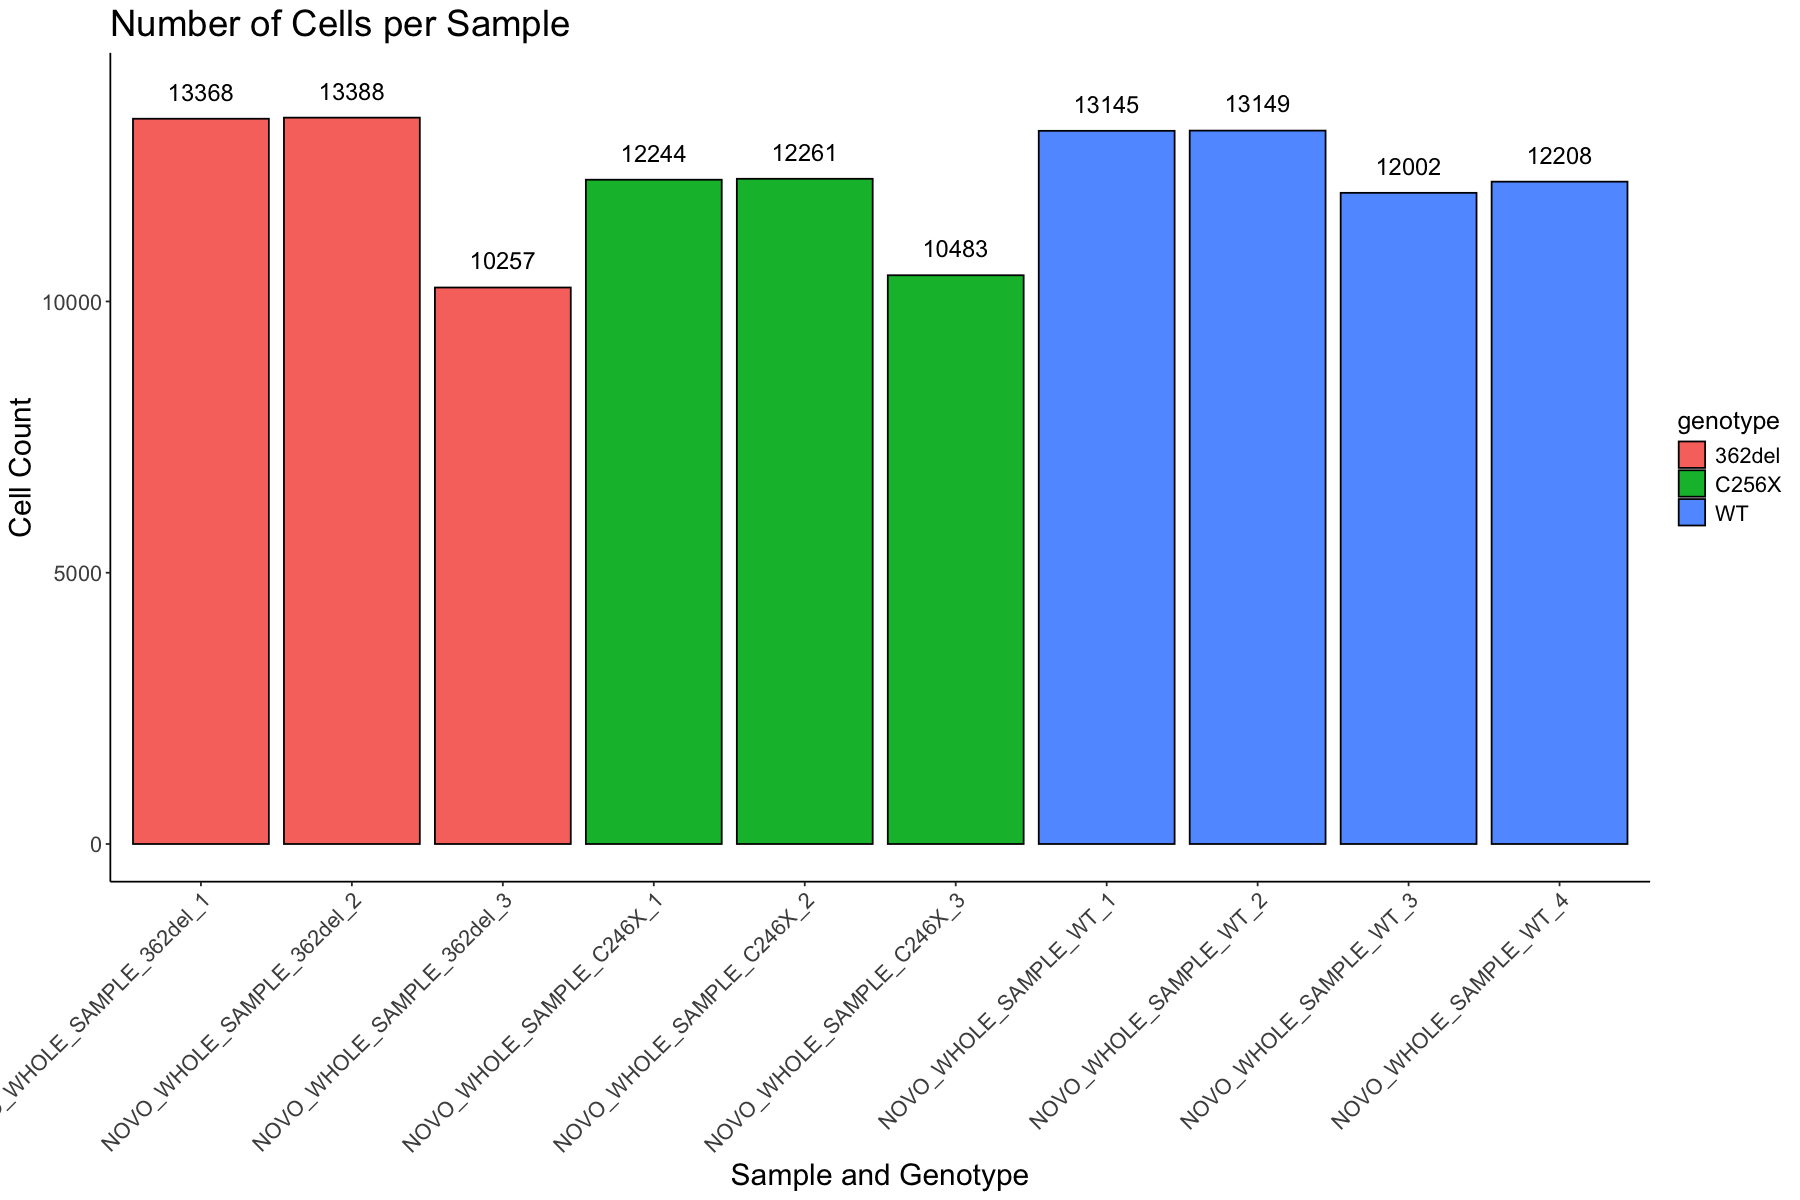

In [112]:
options(repr.plot.width=15, repr.plot.height=10)

Filt_1_NOVOall_SRAT_metadata_final %>%
  distinct(orig.ident, .keep_all = TRUE) %>% # remove the duplicate values so we can have one value per row, keep all cols
  ggplot(aes(x = orig.ident, y = cell_count)) + 
  	geom_col(aes(fill = genotype), color = "black") + 
    geom_text(aes(label = cell_count), nudge_y = 500, size = 5) +
    theme_classic() + 
    labs(x = "Sample and Genotype", y = "Cell Count") + 
    ggtitle("Number of Cells per Sample") + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 22))

[1] 122505


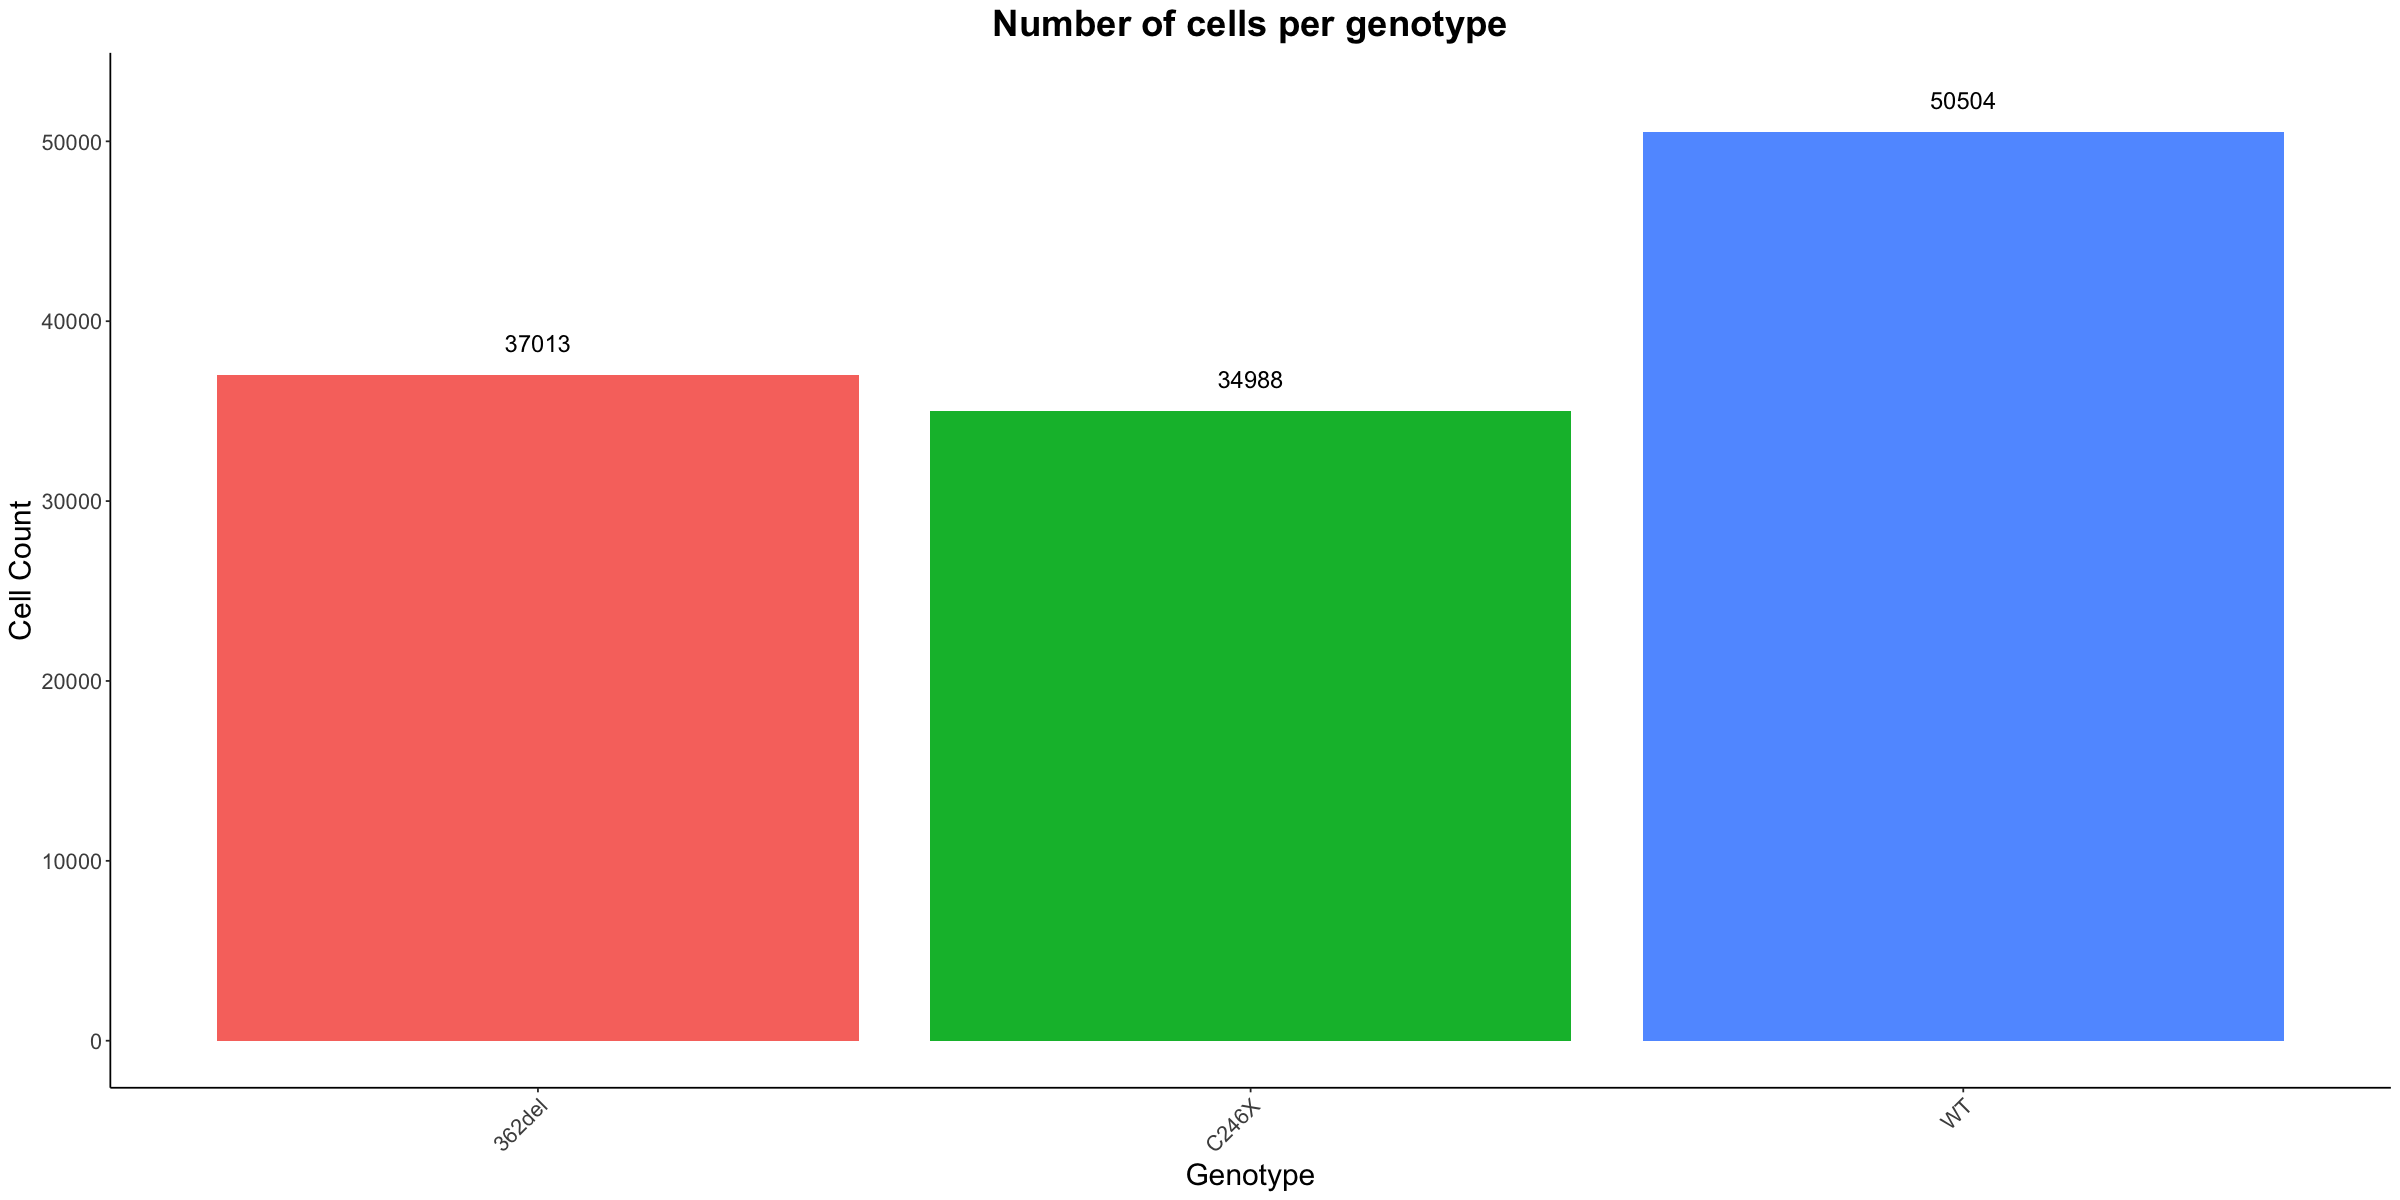

In [63]:
Filt_1_NOVOall_SRAT_metadata_final %>% 
  	ggplot(aes(x=genotype, fill=genotype)) + 
  	geom_bar() +
    geom_text(aes(label = after_stat(count)), stat = "count", nudge_y = 1800, size = 5) +
  	theme_classic() +
  	theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  	theme(plot.title = element_text(hjust=0.5, face="bold"), 
  	      legend.position = "none") +
    labs(x = "Genotype", y = "Cell Count") + 
  	ggtitle("Number of cells per genotype") + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 13),
          axis.text.y = element_text(size = 13),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          legend.text = element_text(size = 13),
          legend.title = element_text(size = 15),
          plot.title = element_text(size = 22))

print(dim(Filt_1_NOVOall_SRAT_metadata1)[1])

## Doublet identification and trimming

In [71]:
Filt_1_NOVOall_SRAT_LAYERS = JoinLayers(Filt_1_NOVOall_SRAT)
NOVO_ALL_DOUBLETS_SCE <- as.SingleCellExperiment(Filt_1_NOVOall_SRAT_LAYERS)

# set seed for reproducibility (pass to BPPARAM arg bc we are dealing with multiple samples)
bp <- MulticoreParam(3, RNGseed=1234)
NOVO_ALL_DOUBLETS_SCE <- scDblFinder(NOVO_ALL_DOUBLETS_SCE, samples = "genotype", BPPARAM = bp) #dbr = multiplet_rate)
table(NOVO_ALL_DOUBLETS_SCE$scDblFinder.class)
NOVO_ALL_DOUBLETS_SCE@colData@listData %>% as.data.frame() %>% head()

Warning message:
“Layer ‘data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”



singlet doublet 
 100963   21542 

orig.ident             nCount_RNA nFeature_RNA percent.mt percent.rb ALL     
1 NOVO_WHOLE_SAMPLE_WT_1 3243.703   1755         1.880567   0.1233159  view_all
2 NOVO_WHOLE_SAMPLE_WT_1 1973.565   1057         3.090854   0.1520092  view_all
3 NOVO_WHOLE_SAMPLE_WT_1 2092.643    928         2.628255   0.2389323  view_all
4 NOVO_WHOLE_SAMPLE_WT_1 1856.522    784         4.039813   0.3770492  view_all
5 NOVO_WHOLE_SAMPLE_WT_1  724.000    465         2.209945   0.2762431  view_all
6 NOVO_WHOLE_SAMPLE_WT_1  703.000    462         3.129445   0.0000000  view_all
  mitoRatio  log10GenesPerUMI cells                    genotype
1 0.01880567 0.9240214        WT_S1_AAACCCAAGCTTTCCC-1 WT      
2 0.03090854 0.9177069        WT_S1_AAACCCAAGGGATCAC-1 WT      
3 0.02628255 0.8936526        WT_S1_AAACCCAAGGTTAAAC-1 WT      
4 0.04039813 0.8854640        WT_S1_AAACCCAAGTTACGGG-1 WT      
5 0.02209945 0.9327611        WT_S1_AAACCCACAAACTCGT-1 WT      
6 0.03129445 0.9359620        WT_S1_AAACCCACAAAGGGTC-1 WT      
  ident                  scDblFinder.sample scDblFinder.class scDblFinder.score
1 NOVO_WHOLE_SAMPLE_WT_1 WT                 doublet           9.905216e-01     
2 NOVO_WHOLE_SAMPLE_WT_1 WT                 doublet           9.296132e-01     
3 NOVO_WHOLE_SAMPLE_WT_1 WT                 singlet           3.063458e-02     
4 NOVO_WHOLE_SAMPLE_WT_1 WT                 singlet           1.201249e-06     
5 NOVO_WHOLE_SAMPLE_WT_1 WT                 singlet           4.949746e-08     
6 NOVO_WHOLE_SAMPLE_WT_1 WT                 singlet           5.024774e-06     
  scDblFinder.weighted scDblFinder.cxds_score
1 0.66862379           0.47697101            
2 0.44935691           0.36913507            
3 0.62416725           0.14747205            
4 0.12679265           0.14771742            
5 0.01442636           0.06675389            
6 0.02182426           0.12673529

### Return Doublet classification to seurat object

In [72]:
meta_scdblfinder <- NOVO_ALL_DOUBLETS_SCE@colData@listData %>% as.data.frame() %>% 
  dplyr::select(starts_with('scDblFinder')) # 'scDblFinder.class')
head(meta_scdblfinder)
rownames(meta_scdblfinder) <- NOVO_ALL_DOUBLETS_SCE@colData@rownames
head(meta_scdblfinder)
Filt_NOVOall_SRAT_SINGLETS <- AddMetaData(object = Filt_1_NOVOall_SRAT , metadata = meta_scdblfinder %>% dplyr::select('scDblFinder.class', ))
head(Filt_NOVOall_SRAT_SINGLETS)

scDblFinder.sample scDblFinder.class scDblFinder.score scDblFinder.weighted
1 WT                 doublet           9.905216e-01      0.66862379          
2 WT                 doublet           9.296132e-01      0.44935691          
3 WT                 singlet           3.063458e-02      0.62416725          
4 WT                 singlet           1.201249e-06      0.12679265          
5 WT                 singlet           4.949746e-08      0.01442636          
6 WT                 singlet           5.024774e-06      0.02182426          
  scDblFinder.cxds_score
1 0.47697101            
2 0.36913507            
3 0.14747205            
4 0.14771742            
5 0.06675389            
6 0.12673529

scDblFinder.sample scDblFinder.class scDblFinder.score
WT_S1_AAACCCAAGCTTTCCC-1 WT                 doublet           9.905216e-01     
WT_S1_AAACCCAAGGGATCAC-1 WT                 doublet           9.296132e-01     
WT_S1_AAACCCAAGGTTAAAC-1 WT                 singlet           3.063458e-02     
WT_S1_AAACCCAAGTTACGGG-1 WT                 singlet           1.201249e-06     
WT_S1_AAACCCACAAACTCGT-1 WT                 singlet           4.949746e-08     
WT_S1_AAACCCACAAAGGGTC-1 WT                 singlet           5.024774e-06     
                         scDblFinder.weighted scDblFinder.cxds_score
WT_S1_AAACCCAAGCTTTCCC-1 0.66862379           0.47697101            
WT_S1_AAACCCAAGGGATCAC-1 0.44935691           0.36913507            
WT_S1_AAACCCAAGGTTAAAC-1 0.62416725           0.14747205            
WT_S1_AAACCCAAGTTACGGG-1 0.12679265           0.14771742            
WT_S1_AAACCCACAAACTCGT-1 0.01442636           0.06675389            
WT_S1_AAACCCACAAAGGGTC-1 0.02182426           0.12673529

orig.ident             nCount_RNA nFeature_RNA
WT_S1_AAACCCAAGCTTTCCC-1 NOVO_WHOLE_SAMPLE_WT_1 3243.703   1755        
WT_S1_AAACCCAAGGGATCAC-1 NOVO_WHOLE_SAMPLE_WT_1 1973.565   1057        
WT_S1_AAACCCAAGGTTAAAC-1 NOVO_WHOLE_SAMPLE_WT_1 2092.643    928        
WT_S1_AAACCCAAGTTACGGG-1 NOVO_WHOLE_SAMPLE_WT_1 1856.522    784        
WT_S1_AAACCCACAAACTCGT-1 NOVO_WHOLE_SAMPLE_WT_1  724.000    465        
WT_S1_AAACCCACAAAGGGTC-1 NOVO_WHOLE_SAMPLE_WT_1  703.000    462        
WT_S1_AAACCCACACTCTCGT-1 NOVO_WHOLE_SAMPLE_WT_1 1893.500    973        
WT_S1_AAACCCACATACTTTC-1 NOVO_WHOLE_SAMPLE_WT_1 1528.032    736        
WT_S1_AAACCCATCAAGGAGC-1 NOVO_WHOLE_SAMPLE_WT_1 2796.595   1293        
WT_S1_AAACCCATCCGACAGC-1 NOVO_WHOLE_SAMPLE_WT_1 1764.522    970        
                         percent.mt percent.rb ALL      mitoRatio  
WT_S1_AAACCCAAGCTTTCCC-1 1.8805668  0.12331585 view_all 0.018805668
WT_S1_AAACCCAAGGGATCAC-1 3.0908541  0.15200922 view_all 0.030908541
WT_S1_AAACCCAAGGTTAAAC-1 2.6282553  0.23893230 view_all 0.026282553
WT_S1_AAACCCAAGTTACGGG-1 4.0398132  0.37704923 view_all 0.040398132
WT_S1_AAACCCACAAACTCGT-1 2.2099448  0.27624309 view_all 0.022099448
WT_S1_AAACCCACAAAGGGTC-1 3.1294452  0.00000000 view_all 0.031294452
WT_S1_AAACCCACACTCTCGT-1 1.6899921  0.00000000 view_all 0.016899921
WT_S1_AAACCCACATACTTTC-1 0.6544364  0.06544364 view_all 0.006544364
WT_S1_AAACCCATCAAGGAGC-1 1.2515217  0.07151553 view_all 0.012515217
WT_S1_AAACCCATCCGACAGC-1 2.9469746  0.17001776 view_all 0.029469746
                         log10GenesPerUMI cells                    genotype
WT_S1_AAACCCAAGCTTTCCC-1 0.9240214        WT_S1_AAACCCAAGCTTTCCC-1 WT      
WT_S1_AAACCCAAGGGATCAC-1 0.9177069        WT_S1_AAACCCAAGGGATCAC-1 WT      
WT_S1_AAACCCAAGGTTAAAC-1 0.8936526        WT_S1_AAACCCAAGGTTAAAC-1 WT      
WT_S1_AAACCCAAGTTACGGG-1 0.8854640        WT_S1_AAACCCAAGTTACGGG-1 WT      
WT_S1_AAACCCACAAACTCGT-1 0.9327611        WT_S1_AAACCCACAAACTCGT-1 WT      
WT_S1_AAACCCACAAAGGGTC-1 0.9359620        WT_S1_AAACCCACAAAGGGTC-1 WT      
WT_S1_AAACCCACACTCTCGT-1 0.9117702        WT_S1_AAACCCACACTCTCGT-1 WT      
WT_S1_AAACCCACATACTTTC-1 0.9003638        WT_S1_AAACCCACATACTTTC-1 WT      
WT_S1_AAACCCATCAAGGAGC-1 0.9027946        WT_S1_AAACCCATCAAGGAGC-1 WT      
WT_S1_AAACCCATCCGACAGC-1 0.9199615        WT_S1_AAACCCATCCGACAGC-1 WT      
                         scDblFinder.class
WT_S1_AAACCCAAGCTTTCCC-1 doublet          
WT_S1_AAACCCAAGGGATCAC-1 doublet          
WT_S1_AAACCCAAGGTTAAAC-1 singlet          
WT_S1_AAACCCAAGTTACGGG-1 singlet          
WT_S1_AAACCCACAAACTCGT-1 singlet          
WT_S1_AAACCCACAAAGGGTC-1 singlet          
WT_S1_AAACCCACACTCTCGT-1 doublet          
WT_S1_AAACCCACATACTTTC-1 singlet          
WT_S1_AAACCCATCAAGGAGC-1 doublet          
WT_S1_AAACCCATCCGACAGC-1 singlet

### QC doublets vs singlets 

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



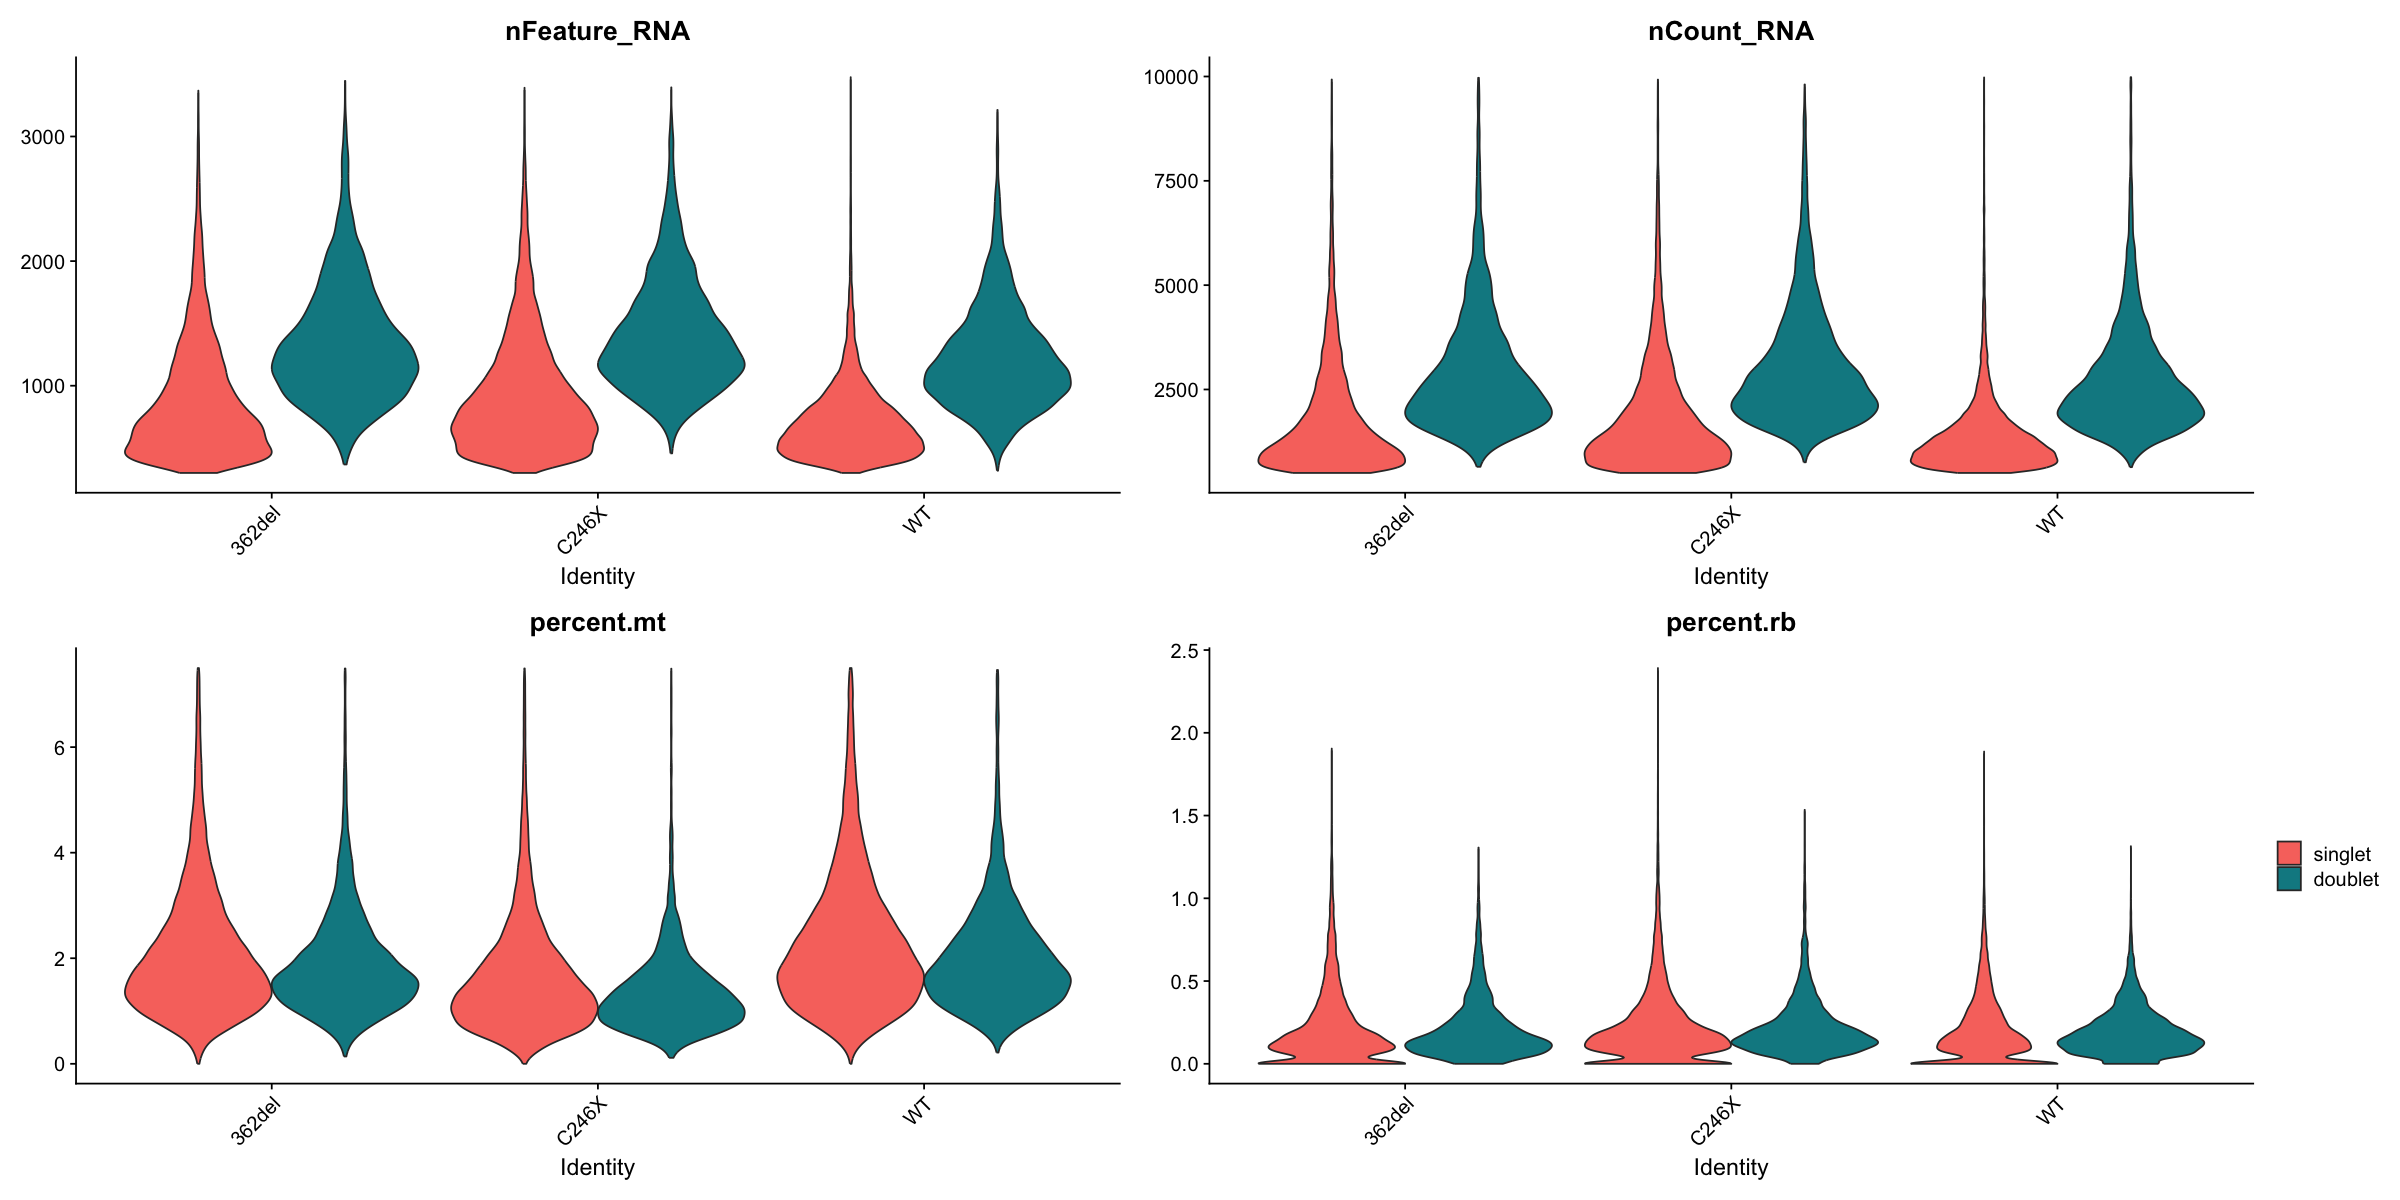

In [77]:
# Doublet stats
# Check how doublets singlets differ in QC measures per sample.
VlnPlot(Filt_NOVOall_SRAT_SINGLETS, group.by = 'genotype', split.by = "scDblFinder.class",
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "percent.rb"), 
        ncol = 2, pt.size = 0) + 
        theme(legend.position = 'right')

### Summary table

In [79]:
doublets_summary <- Filt_NOVOall_SRAT_SINGLETS@meta.data %>% 
  group_by(genotype, scDblFinder.class) %>% 
  summarise(total_count = n(),.groups = 'drop') %>% as.data.frame() %>% ungroup() %>%
  group_by(genotype) %>%
  mutate(countT = sum(total_count)) %>%
  group_by(scDblFinder.class, .add = TRUE) %>%
  mutate(percent = paste0(round(100 * total_count/countT, 2),'%')) %>%
  dplyr::select(-countT)
doublets_summary

genotype scDblFinder.class total_count percent
1 362del   singlet           31241       84.41% 
2 362del   doublet            5772       15.59% 
3 C246X    singlet           29852       85.32% 
4 C246X    doublet            5136       14.68% 
5 WT       singlet           39870       78.94% 
6 WT       doublet           10634       21.06%

### Remove the doublets

In [83]:
NOVOall_SRAT_TRIMMED <- subset(Filt_NOVOall_SRAT_SINGLETS, scDblFinder.class == 'singlet')
head(NOVOall_SRAT_TRIMMED)  

orig.ident             nCount_RNA nFeature_RNA
WT_S1_AAACCCAAGGTTAAAC-1 NOVO_WHOLE_SAMPLE_WT_1 2092.6430   928        
WT_S1_AAACCCAAGTTACGGG-1 NOVO_WHOLE_SAMPLE_WT_1 1856.5215   784        
WT_S1_AAACCCACAAACTCGT-1 NOVO_WHOLE_SAMPLE_WT_1  724.0000   465        
WT_S1_AAACCCACAAAGGGTC-1 NOVO_WHOLE_SAMPLE_WT_1  703.0000   462        
WT_S1_AAACCCACATACTTTC-1 NOVO_WHOLE_SAMPLE_WT_1 1528.0323   736        
WT_S1_AAACCCATCCGACAGC-1 NOVO_WHOLE_SAMPLE_WT_1 1764.5215   970        
WT_S1_AAACCCATCTGCGAGC-1 NOVO_WHOLE_SAMPLE_WT_1 4977.0430  1584        
WT_S1_AAACCCATCTTCCAGC-1 NOVO_WHOLE_SAMPLE_WT_1  586.5108   309        
WT_S1_AAACGAAAGAATAACC-1 NOVO_WHOLE_SAMPLE_WT_1 1281.5741   749        
WT_S1_AAACGAAAGCCTGACC-1 NOVO_WHOLE_SAMPLE_WT_1 1840.7847   898        
                         percent.mt percent.rb ALL      mitoRatio  
WT_S1_AAACCCAAGGTTAAAC-1 2.6282553  0.23893230 view_all 0.026282553
WT_S1_AAACCCAAGTTACGGG-1 4.0398132  0.37704923 view_all 0.040398132
WT_S1_AAACCCACAAACTCGT-1 2.2099448  0.27624309 view_all 0.022099448
WT_S1_AAACCCACAAAGGGTC-1 3.1294452  0.00000000 view_all 0.031294452
WT_S1_AAACCCACATACTTTC-1 0.6544364  0.06544364 view_all 0.006544364
WT_S1_AAACCCATCCGACAGC-1 2.9469746  0.17001776 view_all 0.029469746
WT_S1_AAACCCATCTGCGAGC-1 1.1452583  0.20092252 view_all 0.011452583
WT_S1_AAACCCATCTTCCAGC-1 2.3869980  0.51149957 view_all 0.023869980
WT_S1_AAACGAAAGAATAACC-1 1.8726970  0.07802904 view_all 0.018726970
WT_S1_AAACGAAAGCCTGACC-1 2.2816357  0.05432466 view_all 0.022816357
                         log10GenesPerUMI cells                    genotype
WT_S1_AAACCCAAGGTTAAAC-1 0.8936526        WT_S1_AAACCCAAGGTTAAAC-1 WT      
WT_S1_AAACCCAAGTTACGGG-1 0.8854640        WT_S1_AAACCCAAGTTACGGG-1 WT      
WT_S1_AAACCCACAAACTCGT-1 0.9327611        WT_S1_AAACCCACAAACTCGT-1 WT      
WT_S1_AAACCCACAAAGGGTC-1 0.9359620        WT_S1_AAACCCACAAAGGGTC-1 WT      
WT_S1_AAACCCACATACTTTC-1 0.9003638        WT_S1_AAACCCACATACTTTC-1 WT      
WT_S1_AAACCCATCCGACAGC-1 0.9199615        WT_S1_AAACCCATCCGACAGC-1 WT      
WT_S1_AAACCCATCTGCGAGC-1 0.8655072        WT_S1_AAACCCATCTGCGAGC-1 WT      
WT_S1_AAACCCATCTTCCAGC-1 0.8994618        WT_S1_AAACCCATCTTCCAGC-1 WT      
WT_S1_AAACGAAAGAATAACC-1 0.9249417        WT_S1_AAACGAAAGAATAACC-1 WT      
WT_S1_AAACGAAAGCCTGACC-1 0.9045248        WT_S1_AAACGAAAGCCTGACC-1 WT      
                         scDblFinder.class
WT_S1_AAACCCAAGGTTAAAC-1 singlet          
WT_S1_AAACCCAAGTTACGGG-1 singlet          
WT_S1_AAACCCACAAACTCGT-1 singlet          
WT_S1_AAACCCACAAAGGGTC-1 singlet          
WT_S1_AAACCCACATACTTTC-1 singlet          
WT_S1_AAACCCATCCGACAGC-1 singlet          
WT_S1_AAACCCATCTGCGAGC-1 singlet          
WT_S1_AAACCCATCTTCCAGC-1 singlet          
WT_S1_AAACGAAAGAATAACC-1 singlet          
WT_S1_AAACGAAAGCCTGACC-1 singlet

In [85]:
# save the trimmed file
user_file_directory_trimmed = readline(prompt = "Please enter file directory to save NOVOall_SRAT_TRIMMED: ")
saveRDS(NOVOall_SRAT_TRIMMED, file = user_file_directory_trimmed) # remember to add .rds extension after file name

Please enter file directory to save NOVOall_SRAT_TRIMMED:  ../data_files/NOVOall_SRAT_TRIMMED.rds
